In [161]:
import arcpy
import os
import rasterio as rio
from osgeo import gdal
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import auc
import seaborn as sns
import geopandas
import matplotlib.pyplot as plt
import rasterio
import rasterio.plot
import matplotlib.colors as colors

In [162]:
path='E:\program'
os.chdir(path)

## AED

## calculate total damage

In [129]:
file_path=r'mmr_landuse_2016_final.tif'
with rio.open(file_path) as dem_src:
    luc_mmr = dem_src.read(1)
    luc=gdal.Open(file_path)
    projection = luc.GetProjection()
    geotransform = luc.GetGeoTransform()

In [63]:
from ctypes import wintypes, windll
from functools import cmp_to_key

def winsort(data):
    _StrCmpLogicalW = windll.Shlwapi.StrCmpLogicalW
    _StrCmpLogicalW.argtypes = [wintypes.LPWSTR, wintypes.LPWSTR]
    _StrCmpLogicalW.restype  = wintypes.INT

    cmp_fnc = lambda psz1, psz2: _StrCmpLogicalW(psz1, psz2)
    return sorted(data, key=cmp_to_key(cmp_fnc))

In [483]:
def func_AED_add(total_damage,total_unc):
    total_damage.reverse()
    annual_exceedance_prob=[0.001,0.002,0.004,0.01,0.02,0.04,0.1,0.2,0.5]
    rc=(total_damage[-1]-total_damage[-2])/(annual_exceedance_prob[-1]-annual_exceedance_prob[-2])
    annual_exceedance_prob=[0,0.001,0.002,0.004,0.01,0.02,0.04,0.1,0.2,0.5,1]
    total_damage.append(max(0,total_damage[-1]+rc*((annual_exceedance_prob[-1]-annual_exceedance_prob[-2])))) #damage at p=1
    total_damage.insert(0,1.5*total_damage[1]) #damage at p=0
    total_unc.reverse()
    total_unc=np.array(total_unc)
    first_tuples=[]
    for element in total_unc:
        first_tuples.append(element[0])
    annual_exceedance_prob=[0.001,0.002,0.004,0.01,0.02,0.04,0.1,0.2,0.5]
    rc=(first_tuples[-1]-first_tuples[-2])/(annual_exceedance_prob[-1]-annual_exceedance_prob[-2])
    annual_exceedance_prob=[0,0.001,0.002,0.004,0.01,0.02,0.04,0.1,0.2,0.5,1]
    first_tuples.append(first_tuples[-1]+rc*((annual_exceedance_prob[-1]-annual_exceedance_prob[-2]))) #damage at p=1
    first_tuples.insert(0,1.5*first_tuples[1]) #uncertainty at p=0
    second_tuples=[]
    for element in total_unc:
        second_tuples.append(element[1])
    annual_exceedance_prob=[0.001,0.002,0.004,0.01,0.02,0.04,0.1,0.2,0.5]
    rc=(second_tuples[-1]-second_tuples[-2])/(annual_exceedance_prob[-1]-annual_exceedance_prob[-2])
    annual_exceedance_prob=[0,0.001,0.002,0.004,0.01,0.02,0.04,0.1,0.2,0.5,1]
    second_tuples.append(second_tuples[-1]+rc*((annual_exceedance_prob[-1]-annual_exceedance_prob[-2]))) #damage at p=1
    second_tuples.insert(0,1.5*second_tuples[1]) #uncertainty at p=0    
    for i in range(len(first_tuples)):
        if total_damage[i]-first_tuples[i]<0:
            first_tuples[i]=total_damage[i]
    uncertainties=[first_tuples,second_tuples]
    upper_unc=np.add(total_damage,second_tuples) #point creation
    lower_unc=np.subtract(total_damage,first_tuples)
    lower_unc=lower_unc.clip(min=0)
    AED=auc(annual_exceedance_prob,total_damage)
    AED_lower=auc(annual_exceedance_prob,lower_unc)
    AED_higher=auc(annual_exceedance_prob,upper_unc)
    return AED,AED_lower, AED_higher

In [484]:
def func_calculate_damage_monte_carlo_set(lu_folder,folder_floods,case_name):  
    total_damage_indus=[0,0,0,0,0,0,0,0,0]
    total_damage_indus_cells=[0,0,0,0,0,0,0,0,0]
    total_damage_urb_for=[0,0,0,0,0,0,0,0,0]
    total_damage_urb_for_cells=[0,0,0,0,0,0,0,0,0]
    total_damage_urb_inf=[0,0,0,0,0,0,0,0,0]
    total_damage_urb_inf_cells=[0,0,0,0,0,0,0,0,0]
    total_damage_urb_vil=[0,0,0,0,0,0,0,0,0]
    total_damage_urb_vil_cells=[0,0,0,0,0,0,0,0,0]
    total_damage=[0,0,0,0,0,0,0,0,0]
    total_damage_trans=[0,0,0,0,0,0,0,0,0]
    
    total_indus_unc=[[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0]]
    total_for_unc=[[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0]]
    total_inf_unc=[[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0]]
    total_vil_unc=[[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0]]
    total_unc=[[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0]]
    total_trans_unc=[[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0]]
    #import flood map
    for count,file in enumerate(winsort(os.listdir(folder_floods))):
        file_path=os.path.join(folder_floods,file)
        print(file)
        with rio.open(file_path) as dem_src:
            flood = dem_src.read(1)

        damage_indus=[0,0]
        indus_unc=[0,0]
        damage_urb_for=[0,0]
        form_unc=[0,0]
        damage_urb_inf=[0,0]
        inf_unc=[0,0]
        damage_urb_vil=[0,0]
        vil_unc=[0,0]
        damage_trans=[0,0]
        trans_unc=[0,0]

        file_path_list=[]
        lijst=['Probability of Industry.tif' ,'Probability of Urban-formal.tif','Probability of Urban-informal.tif','Probability of Urban-villages.tif']
        for file in os.listdir(lu_folder):
            if file in lijst:
                file_path_list.append(file)
        for file in file_path_list:
            file_path=os.path.join(lu_folder,file)
            with rio.open(file_path) as dem_src:
                luc_mmr = dem_src.read(1)
                luc=gdal.Open(file_path)
                projection = luc.GetProjection()
                geotransform = luc.GetGeoTransform()  

                if file=='Probability of Industry.tif':
                    for i in range(len(luc_mmr)):
                        for j in range(len(luc_mmr[1])):
                            if flood[i][j]>0:
                                if luc_mmr[i][j]>0:
                                    D=flood[i][j]
                                    y=4*10**4*(65.51*D**0.42)*luc_mmr[i][j]
                                    damage_indus[0]=damage_indus[0]+y/10**6
                                    damage_indus[1]=damage_indus[1]+1

                                    y_lower=y-(4*10**4*(5.81*D**1.35)*luc_mmr[i][j])
                                    indus_unc[0]=indus_unc[0]+y_lower/10**6

                                    y_higher=(4*10**4*(147.06*D**0.29)*luc_mmr[i][j])-y
                                    indus_unc[1]=indus_unc[1]+y_higher/10**6
                if file=='Probability of Urban-formal.tif':
                    for i in range(len(luc_mmr)):
                        for j in range(len(luc_mmr[1])):
                            if flood[i][j]>0:
                                if luc_mmr[i][j]>0:
                                    D=flood[i][j]
                                    y=4*10**4*(35.18*D**0.4)*luc_mmr[i][j]
                                    damage_urb_for[0]=damage_urb_for[0]+y/10**6
                                    damage_urb_for[1]=damage_urb_for[1]+1

                                    y_lower=y-(4*10**4*(4.64*D**1.14)*luc_mmr[i][j])
                                    form_unc[0]=form_unc[0]+y_lower/10**6

                                    y_higher=(4*10**4*(77.13*D**0.28)*luc_mmr[i][j])-y
                                    form_unc[1]=form_unc[1]+y_higher/10**6

                if file=='Probability of Urban-informal.tif':
                    for i in range(len(luc_mmr)):
                        for j in range(len(luc_mmr[1])):
                            if flood[i][j]>0:
                                if luc_mmr[i][j]>0:
                                    D=flood[i][j]
                                    y=4*10**4*(21.99*D**0.4)*luc_mmr[i][j]
                                    damage_urb_inf[0]=damage_urb_inf[0]+y/10**6
                                    damage_urb_inf[1]=damage_urb_inf[1]+1

                                    y_lower=y-4*10**4*(2.9*D**1.15)*luc_mmr[i][j]
                                    inf_unc[0]=inf_unc[0]+y_lower/10**6

                                    y_higher=4*10**4*(48.21*D**0.28)*luc_mmr[i][j]-y
                                    inf_unc[1]=inf_unc[1]+y_higher/10**6
                if file=='Probability of Urban-villages.tif':
                    for i in range(len(luc_mmr)):
                        for j in range(len(luc_mmr[1])):
                            if flood[i][j]>0:
                                if luc_mmr[i][j]>0:
                                    D=flood[i][j]
                                    y=4*10**4*(19.35*D**0.4)*luc_mmr[i][j]
                                    damage_urb_vil[0]=damage_urb_vil[0]+y/10**6
                                    damage_urb_vil[1]=damage_urb_vil[1]+1

                                    y_lower=y-4*10**4*(2.53*D**1.15)*luc_mmr[i][j]
                                    vil_unc[0]=vil_unc[0]+y_lower/10**6

                                    y_higher=4*10**4*(42.46*D**0.28)*luc_mmr[i][j]-y
                                    vil_unc[1]=vil_unc[1]+y_higher/10**6    
                    # add transport
        lu_file=r'land-use models\results_base_case\Land use map_2050-Jan-01.rst'
        with rio.open(lu_file) as dem_src:
            luc_mmr = dem_src.read(1)
            luc=gdal.Open(lu_file)
            projection = luc.GetProjection()
            geotransform = luc.GetGeoTransform()

        damage_trans=[0,0]
        trans_unc=[0,0]

        for i in range(len(luc_mmr)):
            for j in range(len(luc_mmr[1])):
                if flood[i][j]>0:
                    D=flood[i][j]
                    if luc_mmr[i][j]==8:#transportation
                        y=4*10**4*(max(0,5.38*np.log(D)**2+89.58*np.log(D)+211.09))
                        damage_trans[0]=damage_trans[0]+y/10**6
                        damage_trans[1]=damage_trans[1]+1

                        y_lower=y-4*10**4*(max(0,8.86*np.log(D)**2+129.79*np.log(D)+101.98))
                        trans_unc[0]=trans_unc[0]+y_lower/10**6

                        y_higher=4*10**4*(1.59*np.log(D)**2+49.37*np.log(D)+320.2)-y
                        trans_unc[1]=trans_unc[1]+y_higher/10**6

        total_damage_indus[count]=damage_indus[0]
        total_damage_indus_cells[count]=damage_indus[1]
        total_indus_unc[count][0]=indus_unc[0]
        total_indus_unc[count][1]=indus_unc[1]

        total_damage_urb_for[count]=damage_urb_for[0]
        total_damage_urb_for_cells[count]=damage_urb_for[1]
        total_for_unc[count][0]=form_unc[0]
        total_for_unc[count][1]=form_unc[1]


        total_damage_urb_inf[count]=damage_urb_inf[0]
        total_damage_urb_inf_cells[count]=damage_urb_inf[1]
        total_inf_unc[count][0]=inf_unc[0]
        total_inf_unc[count][1]=inf_unc[1]

        total_damage_urb_vil[count]=damage_urb_vil[0]
        total_damage_urb_vil_cells[count]=damage_urb_vil[1]
        total_vil_unc[count][0]=vil_unc[0]
        total_vil_unc[count][1]=vil_unc[1]

        total_damage_trans[count]=damage_trans[0]
        total_trans_unc[count][0]=trans_unc[0]
        total_trans_unc[count][1]=trans_unc[1]

        total_damage[count]=total_damage_indus[count]+total_damage_urb_for[count]+total_damage_urb_inf[count]+total_damage_urb_vil[count]+total_damage_trans[count]
        total_unc[count][0]=total_indus_unc[count][0]+total_for_unc[count][0]+total_inf_unc[count][0]+total_vil_unc[count][0]+total_trans_unc[count][0]
        total_unc[count][1]=total_indus_unc[count][1]+total_for_unc[count][1]+total_inf_unc[count][1]+total_vil_unc[count][1]+total_trans_unc[count][1]
        
    df=pd.DataFrame(columns={'total [M Euro]','Industry [M Euro]','Urban Formal [M Euro]','Urban Informal [M Euro]','Urban Villages [M Euro]','Transportation [M Euro]',case_name})
    df[case_name]=['EAD','unc_low','unc_top']
    df=df.set_index(case_name)
    df=df.reindex(columns=['total [M Euro]','Industry[M Euro]','Urban Formal [M Euro]','Urban Informal [M Euro]','Urban Villages [M Euro]','Transportation [M Euro]'])
    #df=pd.DataFrame(index=['AED','unc_low','unc_top'],columns={'total','Industry','Urban Formal','Urban Informal','Urban Villages','Transportation'})
    df.iloc[0,0],df.iloc[1,0],df.iloc[2,0]=func_AED_add(total_damage,total_unc)
    df.iloc[0,1],df.iloc[1,1],df.iloc[2,1]=func_AED_add(total_damage_indus,total_indus_unc)
    df.iloc[0,2],df.iloc[1,2],df.iloc[2,2]=func_AED_add(total_damage_urb_for,total_for_unc)
    df.iloc[0,3],df.iloc[1,3],df.iloc[2,3]=func_AED_add(total_damage_urb_inf,total_inf_unc)
    df.iloc[0,4],df.iloc[1,4],df.iloc[2,4]=func_AED_add(total_damage_urb_vil,total_vil_unc)
    df.iloc[0,5],df.iloc[1,5],df.iloc[2,5]=func_AED_add(total_damage_trans,total_trans_unc)
    
    #for i in range(6):
    #    df.iloc[1,i]=df.iloc[0,i]-df.iloc[1,i]
    #    df.iloc[2,i]=df.iloc[2,i]-df.iloc[0,i]
        
    splitter=case_name.split("_")
    df.to_csv('output_data_monte_carlo/'+splitter[0]+'_'+splitter[1]+'/'+splitter[2]+'/AED.csv')  
    return df

## Base case

In [485]:
df=func_calculate_damage_monte_carlo_set(r'Monte_carlo Probability maps\base_case',r'combined_rasters\low','base_case_low')

avg_models_low_2.tif
avg_models_low_5.tif
avg_models_low_10.tif
avg_models_low_25.tif
avg_models_low_50.tif
avg_models_low_100.tif
avg_models_low_250.tif
avg_models_low_500.tif
avg_models_low_1000.tif


In [486]:
df

,total [M Euro],Industry[M Euro],Urban Formal [M Euro],Urban Informal [M Euro],Urban Villages [M Euro],Transportation [M Euro]
base_case_low,,,,,,
EAD,7034.718518,1291.940716,3928.926093,350.855459,111.673491,1368.40288
unc_low,892.895514,79.859167,382.156678,33.686333,12.675956,392.403523
unc_top,18190.711757,3476.884607,10119.766483,905.191931,285.37877,3420.570087


In [243]:
df=func_calculate_damage_monte_carlo_set(r'Monte_carlo Probability maps\base_case',r'combined_rasters\high','base_case_high')

avg_models_high_2.tif
avg_models_high_5.tif
avg_models_high_10.tif
avg_models_high_25.tif
avg_models_high_50.tif
avg_models_high_100.tif
avg_models_high_250.tif
avg_models_high_500.tif
avg_models_high_1000.tif
transport


In [244]:
df

,total [M Euro],Industry[M Euro],Urban Formal [M Euro],Urban Informal [M Euro],Urban Villages [M Euro],Transportation [M Euro]
base_case_high,,,,,,
EAD,8056.827626,1481.368480,4536.229254,403.64823,131.08539,1600.036525
unc_low,1131.249162,99.025651,486.660765,42.866196,13.763156,490.238085
unc_top,20106.499618,3916.657973,11307.189188,1006.691515,331.930652,3639.570543


## Resilient urban planning

### 0.1 case

In [245]:
df=func_calculate_damage_monte_carlo_set(r'Monte_carlo Probability maps\results_RUP_0.1',r'combined_rasters\low','RUP0.1_case_low')

avg_models_low_2.tif
avg_models_low_5.tif
avg_models_low_10.tif
avg_models_low_25.tif
avg_models_low_50.tif
avg_models_low_100.tif
avg_models_low_250.tif
avg_models_low_500.tif
avg_models_low_1000.tif
transport


In [246]:
df

,total [M Euro],Industry[M Euro],Urban Formal [M Euro],Urban Informal [M Euro],Urban Villages [M Euro],Transportation [M Euro]
RUP0.1_case_low,,,,,,
EAD,1477.231023,0.014071,0.058975,0.004464,108.750633,1368.40288
unc_low,401.665528,0.000064,0.000549,0.000039,12.623688,392.403523
unc_top,3698.371483,0.051208,0.207821,0.016054,277.526313,3420.570087


In [247]:
df=func_calculate_damage_monte_carlo_set(r'Monte_carlo Probability maps\results_RUP_0.1',r'combined_rasters\high','RUP0.1_case_high')

avg_models_high_2.tif
avg_models_high_5.tif
avg_models_high_10.tif
avg_models_high_25.tif
avg_models_high_50.tif
avg_models_high_100.tif
avg_models_high_250.tif
avg_models_high_500.tif
avg_models_high_1000.tif
transport


In [248]:
df

,total [M Euro],Industry[M Euro],Urban Formal [M Euro],Urban Informal [M Euro],Urban Villages [M Euro],Transportation [M Euro]
RUP0.1_case_high,,,,,,
EAD,1730.951818,0.703182,2.150156,0.178176,127.88378,1600.036525
unc_low,502.458598,0.009701,0.052763,0.004007,13.777248,490.238085
unc_top,3972.441833,2.232289,6.631663,0.557156,323.450183,3639.570543


### 0.2 case

In [249]:
df=func_calculate_damage_monte_carlo_set(r'Monte_carlo Probability maps\results_RUP_0.2',r'combined_rasters\low','RUP0.2_case_low')

avg_models_low_2.tif
avg_models_low_5.tif
avg_models_low_10.tif
avg_models_low_25.tif
avg_models_low_50.tif
avg_models_low_100.tif
avg_models_low_250.tif
avg_models_low_500.tif
avg_models_low_1000.tif
transport


In [250]:
df

,total [M Euro],Industry[M Euro],Urban Formal [M Euro],Urban Informal [M Euro],Urban Villages [M Euro],Transportation [M Euro]
RUP0.2_case_low,,,,,,
EAD,2528.568854,0.270521,842.739959,230.780902,110.240523,1368.40288
unc_low,504.749077,0.002925,81.287616,21.66692,12.66519,392.403523
unc_top,6435.945522,0.897377,2160.859055,595.983446,281.501488,3420.570087


In [251]:
df=func_calculate_damage_monte_carlo_set(r'Monte_carlo Probability maps\results_RUP_0.2',r'combined_rasters\high','RUP0.2_case_high')

avg_models_high_2.tif
avg_models_high_5.tif
avg_models_high_10.tif
avg_models_high_25.tif
avg_models_high_50.tif
avg_models_high_100.tif
avg_models_high_250.tif
avg_models_high_500.tif
avg_models_high_1000.tif
transport


In [252]:
df

,total [M Euro],Industry[M Euro],Urban Formal [M Euro],Urban Informal [M Euro],Urban Villages [M Euro],Transportation [M Euro]
RUP0.2_case_high,,,,,,
EAD,2909.07267,1.963856,969.709564,263.803455,129.523795,1600.036525
unc_low,632.350268,0.034568,102.451472,27.313654,13.781951,490.238085
unc_top,6983.915465,6.130191,2407.981468,658.424575,327.773213,3639.570543


### 0.3 case

In [253]:
df=func_calculate_damage_monte_carlo_set(r'Monte_carlo Probability maps\results_RUP_0.3',r'combined_rasters\low','RUP0.3_case_low')

avg_models_low_2.tif
avg_models_low_5.tif
avg_models_low_10.tif
avg_models_low_25.tif
avg_models_low_50.tif
avg_models_low_100.tif
avg_models_low_250.tif
avg_models_low_500.tif
avg_models_low_1000.tif
transport


In [254]:
df

,total [M Euro],Industry[M Euro],Urban Formal [M Euro],Urban Informal [M Euro],Urban Villages [M Euro],Transportation [M Euro]
RUP0.3_case_low,,,,,,
EAD,3821.487411,0.246082,2142.478136,238.444052,111.122265,1368.40288
unc_low,630.161137,0.002681,205.934937,22.37039,12.664519,392.403523
unc_top,9789.798611,0.818837,5507.857958,615.813117,283.944615,3420.570087


In [255]:
df=func_calculate_damage_monte_carlo_set(r'Monte_carlo Probability maps\results_RUP_0.3',r'combined_rasters\high','RUP0.1_case_high')

avg_models_high_2.tif
avg_models_high_5.tif
avg_models_high_10.tif
avg_models_high_25.tif
avg_models_high_50.tif
avg_models_high_100.tif
avg_models_high_250.tif
avg_models_high_500.tif
avg_models_high_1000.tif
transport


In [256]:
df

,total [M Euro],Industry[M Euro],Urban Formal [M Euro],Urban Informal [M Euro],Urban Villages [M Euro],Transportation [M Euro]
RUP0.1_case_high,,,,,,
EAD,4371.22287,1.835354,2461.926212,272.528333,130.484459,1600.036525
unc_low,790.841092,0.031244,259.988748,28.194279,13.76057,490.238085
unc_top,10688.07975,5.761669,6127.67881,680.26367,330.393072,3639.570543


### 0.4 case

In [257]:
df=func_calculate_damage_monte_carlo_set(r'Monte_carlo Probability maps\results_RUP_0.4',r'combined_rasters\low','RUP0.4_case_low')

avg_models_low_2.tif
avg_models_low_5.tif
avg_models_low_10.tif
avg_models_low_25.tif
avg_models_low_50.tif
avg_models_low_100.tif
avg_models_low_250.tif
avg_models_low_500.tif
avg_models_low_1000.tif
transport


In [258]:
df

,total [M Euro],Industry[M Euro],Urban Formal [M Euro],Urban Informal [M Euro],Urban Villages [M Euro],Transportation [M Euro]
RUP0.4_case_low,,,,,,
EAD,3890.834007,0.234921,2213.783855,238.694497,111.398175,1368.40288
unc_low,636.3636,0.002590,212.087719,22.393784,12.669067,392.403523
unc_top,9975.92964,0.780686,5695.125867,616.461167,284.672154,3420.570087


In [259]:
df=func_calculate_damage_monte_carlo_set(r'Monte_carlo Probability maps\results_RUP_0.4',r'combined_rasters\high','RUP0.4_case_high')

avg_models_high_2.tif
avg_models_high_5.tif
avg_models_high_10.tif
avg_models_high_25.tif
avg_models_high_50.tif
avg_models_high_100.tif
avg_models_high_250.tif
avg_models_high_500.tif
avg_models_high_1000.tif
transport


In [260]:
df

,total [M Euro],Industry[M Euro],Urban Formal [M Euro],Urban Informal [M Euro],Urban Villages [M Euro],Transportation [M Euro]
RUP0.4_case_high,,,,,,
EAD,4452.749151,1.781615,2542.879886,272.829816,130.785419,1600.036525
unc_low,798.574271,0.030161,267.660164,28.224409,13.76029,490.238085
unc_top,10894.888752,5.599372,6333.085793,681.023436,331.173718,3639.570543


### 0.5 case

In [261]:
df=func_calculate_damage_monte_carlo_set(r'Monte_carlo Probability maps\results_RUP_0.5',r'combined_rasters\low','RUP0.5_case_low')

avg_models_low_2.tif
avg_models_low_5.tif
avg_models_low_10.tif
avg_models_low_25.tif
avg_models_low_50.tif
avg_models_low_100.tif
avg_models_low_250.tif
avg_models_low_500.tif
avg_models_low_1000.tif
transport


In [262]:
df

,total [M Euro],Industry[M Euro],Urban Formal [M Euro],Urban Informal [M Euro],Urban Villages [M Euro],Transportation [M Euro]
RUP0.5_case_low,,,,,,
EAD,3973.981532,1.001055,2297.682986,238.693863,111.61655,1368.40288
unc_low,644.193737,0.103045,219.86971,22.393756,12.674531,392.403523
unc_top,10193.556221,3.027036,5911.682178,616.46008,285.232642,3420.570087


In [263]:
df=func_calculate_damage_monte_carlo_set(r'Monte_carlo Probability maps\results_RUP_0.5',r'combined_rasters\high','RUP0.5_case_high')

avg_models_high_2.tif
avg_models_high_5.tif
avg_models_high_10.tif
avg_models_high_25.tif
avg_models_high_50.tif
avg_models_high_100.tif
avg_models_high_250.tif
avg_models_high_500.tif
avg_models_high_1000.tif
transport


In [264]:
df

,total [M Euro],Industry[M Euro],Urban Formal [M Euro],Urban Informal [M Euro],Urban Villages [M Euro],Transportation [M Euro]
RUP0.5_case_high,,,,,,
EAD,4549.891736,2.732751,2638.908801,272.828673,131.023429,1600.036525
unc_low,808.47321,0.144441,277.49595,28.224272,13.762564,490.238085
unc_top,11137.841926,8.255100,6572.857583,681.022747,331.774395,3639.570543


### Ordinary Urban planning

### 0.1 case

In [265]:
df=func_calculate_damage_monte_carlo_set(r'Monte_carlo Probability maps\results_OUP_0.1',r'combined_rasters\low','OUP0.1_case_low')

avg_models_low_2.tif
avg_models_low_5.tif
avg_models_low_10.tif
avg_models_low_25.tif
avg_models_low_50.tif
avg_models_low_100.tif
avg_models_low_250.tif
avg_models_low_500.tif
avg_models_low_1000.tif
transport


In [266]:
df

,total [M Euro],Industry[M Euro],Urban Formal [M Euro],Urban Informal [M Euro],Urban Villages [M Euro],Transportation [M Euro]
OUP0.1_case_low,,,,,,
EAD,1479.614702,0.289586,1.725646,0.185233,109.011357,1368.40288
unc_low,401.737869,0.003137,0.043523,0.004356,12.653447,392.403523
unc_top,3705.550427,0.956790,5.251696,0.569942,278.201912,3420.570087


In [267]:
df=func_calculate_damage_monte_carlo_set(r'Monte_carlo Probability maps\results_OUP_0.1',r'combined_rasters\high','OUP0.1_case_high')

avg_models_high_2.tif
avg_models_high_5.tif
avg_models_high_10.tif
avg_models_high_25.tif
avg_models_high_50.tif
avg_models_high_100.tif
avg_models_high_250.tif
avg_models_high_500.tif
avg_models_high_1000.tif
transport


In [268]:
df

,total [M Euro],Industry[M Euro],Urban Formal [M Euro],Urban Informal [M Euro],Urban Villages [M Euro],Transportation [M Euro]
OUP0.1_case_high,,,,,,
EAD,1741.327629,2.072645,9.99835,1.035501,128.184607,1600.036525
unc_low,502.85992,0.037308,0.36564,0.036281,13.794706,490.238085
unc_top,4002.636183,6.444907,29.314535,3.069644,324.236553,3639.570543


### 0.2 case

In [269]:
df=func_calculate_damage_monte_carlo_set(r'Monte_carlo Probability maps\results_OUP_0.2',r'combined_rasters\low','OUP0.2_case_low')

avg_models_low_2.tif
avg_models_low_5.tif
avg_models_low_10.tif
avg_models_low_25.tif
avg_models_low_50.tif
avg_models_low_100.tif
avg_models_low_250.tif
avg_models_low_500.tif
avg_models_low_1000.tif
transport


In [270]:
df

,total [M Euro],Industry[M Euro],Urban Formal [M Euro],Urban Informal [M Euro],Urban Villages [M Euro],Transportation [M Euro]
OUP0.2_case_low,,,,,,
EAD,2533.362381,0.266960,848.258982,229.98244,110.275257,1368.40288
unc_low,505.256772,0.002887,81.86506,21.593379,12.66609,392.403523
unc_top,6447.76109,0.885307,2174.616845,593.925761,281.587229,3420.570087


In [271]:
df=func_calculate_damage_monte_carlo_set(r'Monte_carlo Probability maps\results_OUP_0.2',r'combined_rasters\high','OUP0.2_case_high')

avg_models_high_2.tif
avg_models_high_5.tif
avg_models_high_10.tif
avg_models_high_25.tif
avg_models_high_50.tif
avg_models_high_100.tif
avg_models_high_250.tif
avg_models_high_500.tif
avg_models_high_1000.tif
transport


In [272]:
df

,total [M Euro],Industry[M Euro],Urban Formal [M Euro],Urban Informal [M Euro],Urban Villages [M Euro],Transportation [M Euro]
OUP0.2_case_high,,,,,,
EAD,2914.347365,1.925796,976.10018,262.905149,129.561177,1600.036525
unc_low,632.986219,0.033685,103.175597,27.221638,13.782324,490.238085
unc_top,6997.286944,6.015931,2423.816811,656.201372,327.863748,3639.570543


### 0.3 case

In [273]:
df=func_calculate_damage_monte_carlo_set(r'Monte_carlo Probability maps\results_OUP_0.3',r'combined_rasters\low','OUP0.3_case_low')

avg_models_low_2.tif
avg_models_low_5.tif
avg_models_low_10.tif
avg_models_low_25.tif
avg_models_low_50.tif
avg_models_low_100.tif
avg_models_low_250.tif
avg_models_low_500.tif
avg_models_low_1000.tif
transport


In [274]:
df

,total [M Euro],Industry[M Euro],Urban Formal [M Euro],Urban Informal [M Euro],Urban Villages [M Euro],Transportation [M Euro]
OUP0.3_case_low,,,,,,
EAD,3821.072138,0.238970,2142.001526,238.468142,111.14872,1368.40288
unc_low,630.119345,0.002626,205.889204,22.372929,12.664242,392.403523
unc_top,9788.65883,0.794612,5506.592314,615.869436,284.020481,3420.570087


In [275]:
df=func_calculate_damage_monte_carlo_set(r'Monte_carlo Probability maps\results_OUP_0.3',r'combined_rasters\high','OUP0.3_case_high')

avg_models_high_2.tif
avg_models_high_5.tif
avg_models_high_10.tif
avg_models_high_25.tif
avg_models_high_50.tif
avg_models_high_100.tif
avg_models_high_250.tif
avg_models_high_500.tif
avg_models_high_1000.tif
transport


In [276]:
df

,total [M Euro],Industry[M Euro],Urban Formal [M Euro],Urban Informal [M Euro],Urban Villages [M Euro],Transportation [M Euro]
OUP0.3_case_high,,,,,,
EAD,4370.727179,1.798332,2461.390547,272.574037,130.513463,1600.036525
unc_low,790.78783,0.030693,259.930296,28.19821,13.759589,490.238085
unc_top,10686.832851,5.644012,6126.352297,680.376683,330.475042,3639.570543


### 0.4 case

In [277]:
df=func_calculate_damage_monte_carlo_set(r'Monte_carlo Probability maps\results_OUP_0.4',r'combined_rasters\low','OUP0.4_case_low')

avg_models_low_2.tif
avg_models_low_5.tif
avg_models_low_10.tif
avg_models_low_25.tif
avg_models_low_50.tif
avg_models_low_100.tif
avg_models_low_250.tif
avg_models_low_500.tif
avg_models_low_1000.tif
transport


In [278]:
df

,total [M Euro],Industry[M Euro],Urban Formal [M Euro],Urban Informal [M Euro],Urban Villages [M Euro],Transportation [M Euro]
OUP0.4_case_low,,,,,,
EAD,3890.994501,0.243982,2213.940324,238.694008,111.407735,1368.40288
unc_low,636.385313,0.002683,212.108331,22.393761,12.669307,392.403523
unc_top,9976.374194,0.809503,5695.532213,616.460106,284.696714,3420.570087


In [279]:
df=func_calculate_damage_monte_carlo_set(r'Monte_carlo Probability maps\results_OUP_0.4',r'combined_rasters\high','OUP0.4_case_high')

avg_models_high_2.tif
avg_models_high_5.tif
avg_models_high_10.tif
avg_models_high_25.tif
avg_models_high_50.tif
avg_models_high_100.tif
avg_models_high_250.tif
avg_models_high_500.tif
avg_models_high_1000.tif
transport


In [280]:
df

,total [M Euro],Industry[M Euro],Urban Formal [M Euro],Urban Informal [M Euro],Urban Villages [M Euro],Transportation [M Euro]
OUP0.4_case_high,,,,,,
EAD,4452.947894,1.807438,2543.041597,272.829719,130.795904,1600.036525
unc_low,798.598693,0.031003,267.682559,28.22431,13.760398,490.238085
unc_top,10895.381571,5.666652,6333.48381,681.023707,331.200147,3639.570543


### 0.5 case

In [281]:
df=func_calculate_damage_monte_carlo_set(r'Monte_carlo Probability maps\results_OUP_0.5',r'combined_rasters\low','OUP0.5_case_low')

avg_models_low_2.tif
avg_models_low_5.tif
avg_models_low_10.tif
avg_models_low_25.tif
avg_models_low_50.tif
avg_models_low_100.tif
avg_models_low_250.tif
avg_models_low_500.tif
avg_models_low_1000.tif
transport


In [282]:
df

,total [M Euro],Industry[M Euro],Urban Formal [M Euro],Urban Informal [M Euro],Urban Villages [M Euro],Transportation [M Euro]
OUP0.5_case_low,,,,,,
EAD,3972.395725,1.162925,2295.947328,238.69222,111.616584,1368.40288
unc_low,644.031593,0.213610,219.700421,22.393718,12.674532,392.403523
unc_top,10189.488949,3.442488,5907.214919,616.454937,285.23273,3420.570087


In [283]:
df=func_calculate_damage_monte_carlo_set(r'Monte_carlo Probability maps\results_OUP_0.5',r'combined_rasters\high','OUP0.5_case_high')

avg_models_high_2.tif
avg_models_high_5.tif
avg_models_high_10.tif
avg_models_high_25.tif
avg_models_high_50.tif
avg_models_high_100.tif
avg_models_high_250.tif
avg_models_high_500.tif
avg_models_high_1000.tif
transport


In [284]:
df

,total [M Euro],Industry[M Euro],Urban Formal [M Euro],Urban Informal [M Euro],Urban Villages [M Euro],Transportation [M Euro]
OUP0.5_case_high,,,,,,
EAD,4548.031575,2.945640,2636.904748,272.821412,131.023506,1600.036525
unc_low,808.26447,0.211920,277.27596,28.223962,13.762575,490.238085
unc_top,11133.411542,8.879836,6567.885316,681.00161,331.774493,3639.570543


# Impact of zoning

In [488]:
def func_calculate_damage_monte_carlo_set(lu_folder,folder_floods,case_name):  
    total_damage_indus=[0,0,0,0,0,0,0,0,0]
    total_damage_indus_cells=[0,0,0,0,0,0,0,0,0]
    total_damage_urb_for=[0,0,0,0,0,0,0,0,0]
    total_damage_urb_for_cells=[0,0,0,0,0,0,0,0,0]
    total_damage_urb_inf=[0,0,0,0,0,0,0,0,0]
    total_damage_urb_inf_cells=[0,0,0,0,0,0,0,0,0]
    total_damage_urb_vil=[0,0,0,0,0,0,0,0,0]
    total_damage_urb_vil_cells=[0,0,0,0,0,0,0,0,0]
    total_damage=[0,0,0,0,0,0,0,0,0]
    total_damage_trans=[0,0,0,0,0,0,0,0,0]
    
    total_indus_unc=[[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0]]
    total_for_unc=[[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0]]
    total_inf_unc=[[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0]]
    total_vil_unc=[[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0]]
    total_unc=[[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0]]
    total_trans_unc=[[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0]]
    #import flood map
    for count,file in enumerate(winsort(os.listdir(folder_floods))):
        file_path=os.path.join(folder_floods,file)
        with rio.open(file_path) as dem_src:
            flood = dem_src.read(1)

        damage_indus=[0,0]
        indus_unc=[0,0]
        damage_urb_for=[0,0]
        form_unc=[0,0]
        damage_urb_inf=[0,0]
        inf_unc=[0,0]
        damage_urb_vil=[0,0]
        vil_unc=[0,0]
        damage_trans=[0,0]
        trans_unc=[0,0]

        file_path_list=[]
        lijst=['Probability of Industry.tif' ,'Probability of Urban-formal.tif','Probability of Urban-informal.tif','Probability of Urban-villages.tif']
        for file in os.listdir(lu_folder):
            if file in lijst:
                file_path_list.append(file)
        for file in file_path_list:
            file_path=os.path.join(lu_folder,file)
            with rio.open(file_path) as dem_src:
                luc_mmr = dem_src.read(1)
                luc=gdal.Open(file_path)
                projection = luc.GetProjection()
                geotransform = luc.GetGeoTransform()  

                if file=='Probability of Industry.tif':
                    for i in range(len(luc_mmr)):
                        for j in range(len(luc_mmr[1])):
                            if flood[i][j]>0:
                                if luc_mmr[i][j]>0:
                                    D=flood[i][j]
                                    y=4*10**4*(65.51*D**0.42)*luc_mmr[i][j]
                                    damage_indus[0]=damage_indus[0]+y/10**6
                                    damage_indus[1]=damage_indus[1]+1

                                    y_lower=y-(4*10**4*(5.81*D**1.35)*luc_mmr[i][j])
                                    indus_unc[0]=indus_unc[0]+y_lower/10**6

                                    y_higher=(4*10**4*(147.06*D**0.29)*luc_mmr[i][j])-y
                                    indus_unc[1]=indus_unc[1]+y_higher/10**6
                if file=='Probability of Urban-formal.tif':
                    for i in range(len(luc_mmr)):
                        for j in range(len(luc_mmr[1])):
                            if flood[i][j]>0:
                                if luc_mmr[i][j]>0:
                                    D=flood[i][j]
                                    y=4*10**4*(35.18*D**0.4)*luc_mmr[i][j]
                                    damage_urb_for[0]=damage_urb_for[0]+y/10**6
                                    damage_urb_for[1]=damage_urb_for[1]+1

                                    y_lower=y-(4*10**4*(4.64*D**1.14)*luc_mmr[i][j])
                                    form_unc[0]=form_unc[0]+y_lower/10**6

                                    y_higher=(4*10**4*(77.13*D**0.28)*luc_mmr[i][j])-y
                                    form_unc[1]=form_unc[1]+y_higher/10**6

                if file=='Probability of Urban-informal.tif':
                    for i in range(len(luc_mmr)):
                        for j in range(len(luc_mmr[1])):
                            if flood[i][j]>0:
                                if luc_mmr[i][j]>0:
                                    D=flood[i][j]
                                    y=4*10**4*(21.99*D**0.4)*luc_mmr[i][j]
                                    damage_urb_inf[0]=damage_urb_inf[0]+y/10**6
                                    damage_urb_inf[1]=damage_urb_inf[1]+1

                                    y_lower=y-4*10**4*(2.9*D**1.15)*luc_mmr[i][j]
                                    inf_unc[0]=inf_unc[0]+y_lower/10**6

                                    y_higher=4*10**4*(48.21*D**0.28)*luc_mmr[i][j]-y
                                    inf_unc[1]=inf_unc[1]+y_higher/10**6
                if file=='Probability of Urban-villages.tif':
                    for i in range(len(luc_mmr)):
                        for j in range(len(luc_mmr[1])):
                            if flood[i][j]>0:
                                if luc_mmr[i][j]>0:
                                    D=flood[i][j]
                                    y=4*10**4*(19.35*D**0.4)*luc_mmr[i][j]
                                    damage_urb_vil[0]=damage_urb_vil[0]+y/10**6
                                    damage_urb_vil[1]=damage_urb_vil[1]+1

                                    y_lower=y-4*10**4*(2.53*D**1.15)*luc_mmr[i][j]
                                    vil_unc[0]=vil_unc[0]+y_lower/10**6

                                    y_higher=4*10**4*(42.46*D**0.28)*luc_mmr[i][j]-y
                                    vil_unc[1]=vil_unc[1]+y_higher/10**6    
                    # add transport
        lu_file=r'land-use models\results_base_case\Land use map_2050-Jan-01.rst'
        with rio.open(lu_file) as dem_src:
            luc_mmr = dem_src.read(1)
            luc=gdal.Open(lu_file)
            projection = luc.GetProjection()
            geotransform = luc.GetGeoTransform()

        damage_trans=[0,0]
        trans_unc=[0,0]

        for i in range(len(luc_mmr)):
            for j in range(len(luc_mmr[1])):
                if flood[i][j]>0:
                    D=flood[i][j]
                    if luc_mmr[i][j]==8:#transportation
                        y=4*10**4*(max(0,5.38*np.log(D)**2+89.58*np.log(D)+211.09))
                        damage_trans[0]=damage_trans[0]+y/10**6
                        damage_trans[1]=damage_trans[1]+1

                        y_lower=y-4*10**4*(max(0,8.86*np.log(D)**2+129.79*np.log(D)+101.98))
                        trans_unc[0]=trans_unc[0]+y_lower/10**6

                        y_higher=4*10**4*(1.59*np.log(D)**2+49.37*np.log(D)+320.2)-y
                        trans_unc[1]=trans_unc[1]+y_higher/10**6

        total_damage_indus[count]=damage_indus[0]
        total_damage_indus_cells[count]=damage_indus[1]
        total_indus_unc[count][0]=indus_unc[0]
        total_indus_unc[count][1]=indus_unc[1]

        total_damage_urb_for[count]=damage_urb_for[0]
        total_damage_urb_for_cells[count]=damage_urb_for[1]
        total_for_unc[count][0]=form_unc[0]
        total_for_unc[count][1]=form_unc[1]


        total_damage_urb_inf[count]=damage_urb_inf[0]
        total_damage_urb_inf_cells[count]=damage_urb_inf[1]
        total_inf_unc[count][0]=inf_unc[0]
        total_inf_unc[count][1]=inf_unc[1]

        total_damage_urb_vil[count]=damage_urb_vil[0]
        total_damage_urb_vil_cells[count]=damage_urb_vil[1]
        total_vil_unc[count][0]=vil_unc[0]
        total_vil_unc[count][1]=vil_unc[1]

        total_damage_trans[count]=damage_trans[0]
        total_trans_unc[count][0]=trans_unc[0]
        total_trans_unc[count][1]=trans_unc[1]

        total_damage[count]=total_damage_indus[count]+total_damage_urb_for[count]+total_damage_urb_inf[count]+total_damage_urb_vil[count]#+total_damage_trans[count]
        total_unc[count][0]=total_indus_unc[count][0]+total_for_unc[count][0]+total_inf_unc[count][0]+total_vil_unc[count][0]#+total_trans_unc[count][0]
        total_unc[count][1]=total_indus_unc[count][1]+total_for_unc[count][1]+total_inf_unc[count][1]+total_vil_unc[count][1]#+total_trans_unc[count][1]
        
    df=pd.DataFrame(columns={'total [M Euro]','Industry [M Euro]','Urban Formal [M Euro]','Urban Informal [M Euro]','Urban Villages [M Euro]',case_name})
    df[case_name]=['EAD','unc_low','unc_top']
    df=df.set_index(case_name)
    df=df.reindex(columns=['total [M Euro]','Industry[M Euro]','Urban Formal [M Euro]','Urban Informal [M Euro]','Urban Villages [M Euro]'])
    #df=pd.DataFrame(index=['AED','unc_low','unc_top'],columns={'total','Industry','Urban Formal','Urban Informal','Urban Villages','Transportation'})
    df.iloc[0,0],df.iloc[1,0],df.iloc[2,0]=func_AED_add(total_damage,total_unc)
    df.iloc[0,1],df.iloc[1,1],df.iloc[2,1]=func_AED_add(total_damage_indus,total_indus_unc)
    df.iloc[0,2],df.iloc[1,2],df.iloc[2,2]=func_AED_add(total_damage_urb_for,total_for_unc)
    df.iloc[0,3],df.iloc[1,3],df.iloc[2,3]=func_AED_add(total_damage_urb_inf,total_inf_unc)
    df.iloc[0,4],df.iloc[1,4],df.iloc[2,4]=func_AED_add(total_damage_urb_vil,total_vil_unc)
    #df.iloc[0,5],df.iloc[1,5],df.iloc[2,5]=func_AED_add(total_damage_trans,total_trans_unc)
    
    for i in range(5):
        df.iloc[1,i]=df.iloc[0,i]-df.iloc[1,i]
        df.iloc[2,i]=df.iloc[2,i]-df.iloc[0,i]  
    return df

### RUP

### 4.5

In [489]:
df1=func_calculate_damage_monte_carlo_set(r'Monte_carlo Probability maps\results_RUP_0.1',r'combined_rasters\low','RUP0.1_case_low')
df2=func_calculate_damage_monte_carlo_set(r'Monte_carlo Probability maps\results_RUP_0.2',r'combined_rasters\low','RUP0.2_case_low')
df3=func_calculate_damage_monte_carlo_set(r'Monte_carlo Probability maps\results_RUP_0.3',r'combined_rasters\low','RUP0.3_case_low')
df4=func_calculate_damage_monte_carlo_set(r'Monte_carlo Probability maps\results_RUP_0.4',r'combined_rasters\low','RUP0.4_case_low')
df5=func_calculate_damage_monte_carlo_set(r'Monte_carlo Probability maps\results_RUP_0.5',r'combined_rasters\low','RUP0.5_case_low')
df51=func_calculate_damage_monte_carlo_set(r'Monte_carlo Probability maps\results_RUP_0.6',r'combined_rasters\low','RUP0.6_case_low')
df52=func_calculate_damage_monte_carlo_set(r'Monte_carlo Probability maps\results_RUP_0.7',r'combined_rasters\low','RUP0.7_case_low')
df53=func_calculate_damage_monte_carlo_set(r'Monte_carlo Probability maps\results_RUP_0.8',r'combined_rasters\low','RUP0.8_case_low')


In [529]:
y_errors_RUP_45=np.array([[df1.iloc[1,0],df1.iloc[2,0]],[df2.iloc[1,0],df2.iloc[2,0]],[df3.iloc[1,0],df3.iloc[2,0]],[df4.iloc[1,0],df4.iloc[2,0]],[df5.iloc[1,0],df5.iloc[2,0]],[df51.iloc[1,0],df51.iloc[2,0]],[df52.iloc[1,0],df52.iloc[2,0]],
                          [df53.iloc[1,0],df53.iloc[2,0]],[0,0]])

In [530]:
y_values_RUP_45=[df1.iloc[0,0],df2.iloc[0,0],df3.iloc[0,0],df4.iloc[0,0],df5.iloc[0,0],df51.iloc[0,0],df52.iloc[0,0],df53.iloc[0,0],0]
#x_pos=[0.1,0.2,0.3,0.4,0.5]
labels=['0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','base-case']
x_pos=np.arange(len(labels))

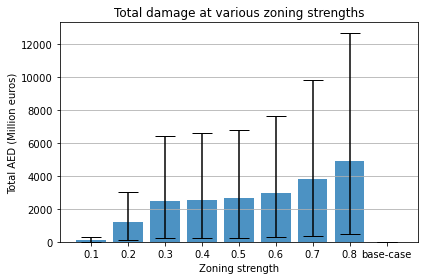

In [531]:
# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, y_values_RUP_45,
       yerr=y_errors_RUP_45.T,
       #align='center',
       alpha=0.8,
       ecolor='black',
       capsize=10)
ax.set_ylabel('Total AED (Million euros)')
ax.set_xlabel('Zoning strength')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('Total damage at various zoning strengths')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
#plt.savefig('bar_plot_with_error_bars.png')
plt.show()

### 8.5

In [540]:
df6=func_calculate_damage_monte_carlo_set(r'Monte_carlo Probability maps\results_RUP_0.1',r'combined_rasters\high','RUP0.1_case_high')
df7=func_calculate_damage_monte_carlo_set(r'Monte_carlo Probability maps\results_RUP_0.2',r'combined_rasters\high','RUP0.2_case_high')
df8=func_calculate_damage_monte_carlo_set(r'Monte_carlo Probability maps\results_RUP_0.3',r'combined_rasters\high','RUP0.3_case_high')
df9=func_calculate_damage_monte_carlo_set(r'Monte_carlo Probability maps\results_RUP_0.4',r'combined_rasters\high','RUP0.4_case_high')
df10=func_calculate_damage_monte_carlo_set(r'Monte_carlo Probability maps\results_RUP_0.5',r'combined_rasters\high','RUP0.5_case_high')
df101=func_calculate_damage_monte_carlo_set(r'Monte_carlo Probability maps\results_RUP_0.6',r'combined_rasters\high','RUP0.6_case_high')
df102=func_calculate_damage_monte_carlo_set(r'Monte_carlo Probability maps\results_RUP_0.7',r'combined_rasters\high','RUP0.7_case_high')
df103=func_calculate_damage_monte_carlo_set(r'Monte_carlo Probability maps\results_RUP_0.8',r'combined_rasters\high','RUP0.8_case_high')
#df14=func_calculate_damage_monte_carlo_set(r'Monte_carlo Probability maps\results_RUP_0.9',r'combined_rasters\high','RUP0.9_case_high')

In [541]:
y_errors_RUP_85=np.array([[df6.iloc[1,0],df6.iloc[2,0]],[df7.iloc[1,0],df7.iloc[2,0]],[df8.iloc[1,0],df8.iloc[2,0]],[df9.iloc[1,0],df9.iloc[2,0]],[df10.iloc[1,0],df10.iloc[2,0]],[df101.iloc[1,0],df101.iloc[2,0]],[df102.iloc[1,0],df102.iloc[2,0]],
                          [df103.iloc[1,0],df103.iloc[2,0]],[0,0]])

In [542]:
y_values_RUP_85=[df6.iloc[0,0],df7.iloc[0,0],df8.iloc[0,0],df9.iloc[0,0],df10.iloc[0,0],df101.iloc[0,0],df102.iloc[0,0],df103.iloc[0,0],0]
#x_pos=[0.1,0.2,0.3,0.4,0.5]
labels=['0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','base-case']
x_pos=np.arange(len(labels))

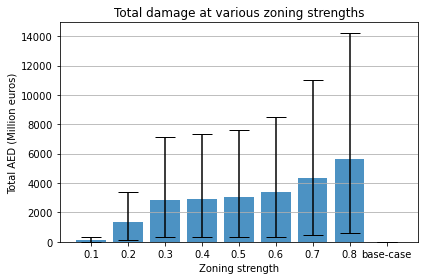

In [543]:
# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, y_values_RUP_85,
       yerr=y_errors_RUP_85.T,
       #align='center',
       alpha=0.8,
       ecolor='black',
       capsize=10)
ax.set_ylabel('Total AED (Million euros)')
ax.set_xlabel('Zoning strength')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('Total damage at various zoning strengths')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
#plt.savefig('bar_plot_with_error_bars.png')
plt.show()

## OUP

### 4.5

In [506]:
df11=func_calculate_damage_monte_carlo_set(r'Monte_carlo Probability maps\results_OUP_0.1',r'combined_rasters\low','OUP0.1_case_low')
df12=func_calculate_damage_monte_carlo_set(r'Monte_carlo Probability maps\results_OUP_0.2',r'combined_rasters\low','OUP0.2_case_low')
df13=func_calculate_damage_monte_carlo_set(r'Monte_carlo Probability maps\results_OUP_0.3',r'combined_rasters\low','OUP0.3_case_low')
df14=func_calculate_damage_monte_carlo_set(r'Monte_carlo Probability maps\results_OUP_0.4',r'combined_rasters\low','OUP0.4_case_low')
df15=func_calculate_damage_monte_carlo_set(r'Monte_carlo Probability maps\results_OUP_0.5',r'combined_rasters\low','OUP0.5_case_low')
df151=func_calculate_damage_monte_carlo_set(r'Monte_carlo Probability maps\results_OUP_0.6',r'combined_rasters\low','OUP0.6_case_low')
df152=func_calculate_damage_monte_carlo_set(r'Monte_carlo Probability maps\results_OUP_0.7',r'combined_rasters\low','OUP0.7_case_low')
df153=func_calculate_damage_monte_carlo_set(r'Monte_carlo Probability maps\results_OUP_0.8',r'combined_rasters\low','OUP0.8_case_low')
df154=func_calculate_damage_monte_carlo_set(r'Monte_carlo Probability maps\results_OUP_0.9',r'combined_rasters\low','OUP0.9_case_low')

In [544]:
y_errors_OUP_45=np.array([[df11.iloc[1,0],df11.iloc[2,0]],[df12.iloc[1,0],df12.iloc[2,0]],[df13.iloc[1,0],df13.iloc[2,0]],[df14.iloc[1,0],df14.iloc[2,0]],[df15.iloc[1,0],df15.iloc[2,0]],[df151.iloc[1,0],df151.iloc[2,0]],
                          [df152.iloc[1,0],df152.iloc[2,0]],[df153.iloc[1,0],df153.iloc[2,0]],[0,0]])

In [546]:
y_values_OUP_45=[df11.iloc[0,0],df12.iloc[0,0],df13.iloc[0,0],df14.iloc[0,0],df15.iloc[0,0],df151.iloc[0,0],df152.iloc[0,0],df153.iloc[0,0],0]
#x_pos=[0.1,0.2,0.3,0.4,0.5]
labels=['0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','base-case']
x_pos=np.arange(len(labels))

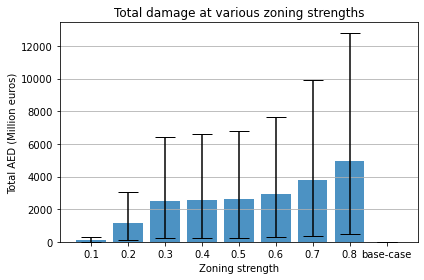

In [547]:
# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, y_values_OUP_45,
       yerr=y_errors_OUP_45.T,
       #align='center',
       alpha=0.8,
       ecolor='black',
       capsize=10)
ax.set_ylabel('Total AED (Million euros)')
ax.set_xlabel('Zoning strength')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('Total damage at various zoning strengths')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
#plt.savefig('bar_plot_with_error_bars.png')
plt.show()

### 8.5

In [512]:
df16=func_calculate_damage_monte_carlo_set(r'Monte_carlo Probability maps\results_OUP_0.1',r'combined_rasters\high','OUP0.1_case_high')
df17=func_calculate_damage_monte_carlo_set(r'Monte_carlo Probability maps\results_OUP_0.2',r'combined_rasters\high','OUP0.2_case_high')
df18=func_calculate_damage_monte_carlo_set(r'Monte_carlo Probability maps\results_OUP_0.3',r'combined_rasters\high','OUP0.3_case_high')
df19=func_calculate_damage_monte_carlo_set(r'Monte_carlo Probability maps\results_OUP_0.4',r'combined_rasters\high','OUP0.4_case_high')
df20=func_calculate_damage_monte_carlo_set(r'Monte_carlo Probability maps\results_OUP_0.5',r'combined_rasters\high','OUP0.5_case_high')
df201=func_calculate_damage_monte_carlo_set(r'Monte_carlo Probability maps\results_OUP_0.6',r'combined_rasters\high','OUP0.6_case_high')
df202=func_calculate_damage_monte_carlo_set(r'Monte_carlo Probability maps\results_OUP_0.7',r'combined_rasters\high','OUP0.7_case_high')
df203=func_calculate_damage_monte_carlo_set(r'Monte_carlo Probability maps\results_OUP_0.8',r'combined_rasters\high','OUP0.8_case_high')
df204=func_calculate_damage_monte_carlo_set(r'Monte_carlo Probability maps\results_OUP_0.9',r'combined_rasters\high','OUP0.9_case_high')

In [548]:
y_errors_OUP_85=np.array([[df16.iloc[1,0],df16.iloc[2,0]],[df17.iloc[1,0],df17.iloc[2,0]],[df18.iloc[1,0],df18.iloc[2,0]],[df19.iloc[1,0],df19.iloc[2,0]],[df20.iloc[1,0],df20.iloc[2,0]],[df201.iloc[1,0],df201.iloc[2,0]],
                          [df202.iloc[1,0],df202.iloc[2,0]],[df203.iloc[1,0],df203.iloc[2,0]],[0,0]])

In [550]:
y_values_OUP_85=[df16.iloc[0,0],df17.iloc[0,0],df18.iloc[0,0],df19.iloc[0,0],df20.iloc[0,0],df201.iloc[0,0],df202.iloc[0,0],df203.iloc[0,0],0]
#x_pos=[0.1,0.2,0.3,0.4,0.5]
labels=['0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','base-case']
x_pos=np.arange(len(labels))

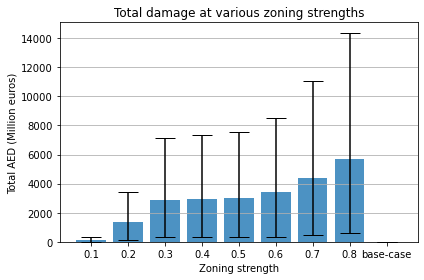

In [551]:
# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, y_values_OUP_85,
       yerr=y_errors_OUP_85.T,
       #align='center',
       alpha=0.8,
       ecolor='black',
       capsize=10)
ax.set_ylabel('Total AED (Million euros)')
ax.set_xlabel('Zoning strength')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('Total damage at various zoning strengths')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
#plt.savefig('bar_plot_with_error_bars.png')
plt.show()

## base-case

In [552]:
df21=func_calculate_damage_monte_carlo_set(r'Monte_carlo Probability maps\base_case',r'combined_rasters\low','base_case_low')
df22=func_calculate_damage_monte_carlo_set(r'Monte_carlo Probability maps\base_case',r'combined_rasters\high','base_case_high')

In [553]:
y_errors_base_case_low=np.array([[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[df21.iloc[1,0],df21.iloc[2,0]]])

In [554]:
y_values_base_case_low=[0,0,0,0,0,0,0,0,df21.iloc[0,0]]
#x_pos=[0.1,0.2,0.3,0.4,0.5]
labels=['0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','base-case']
x_pos=np.arange(len(labels))

In [555]:
y_errors_base_case_high=np.array([[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[df22.iloc[1,0],df22.iloc[2,0]]])

In [556]:
y_values_base_case_high=[0,0,0,0,0,0,0,0,df22.iloc[0,0]]
#x_pos=[0.1,0.2,0.3,0.4,0.5]
labels=['0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','base-case']
x_pos=np.arange(len(labels))

# Comparison of OUP4.5,8.5 and RUP4.5, 8.5

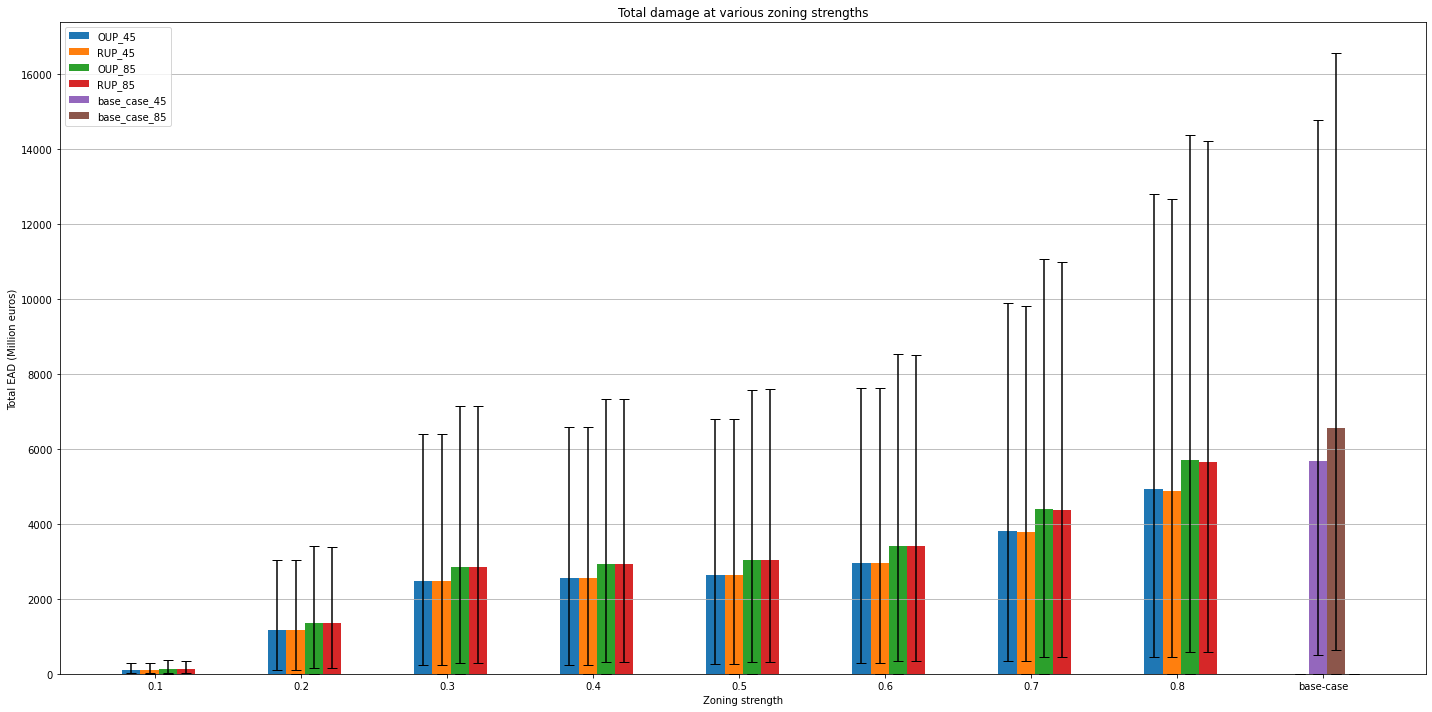

In [557]:
labels=['0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','base-case']
x_pos=np.arange(len(labels))
x = np.arange(len(y_values_OUP_45))
# Build the plot
fig, ax = plt.subplots(figsize=(20,10))
#ax.bar(x_pos, y_values_OUP_85,
#       yerr=y_errors_OUP_85.T,
#       #align='center',
#       alpha=0.8,
#       ecolor='black',
#       capsize=10)
barwidth=0.125
ax.bar(x, y_values_OUP_45, width=barwidth, 
       label='OUP_45', yerr=y_errors_OUP_45.T,capsize=5) # <----- 
ax.bar(x+ barwidth, y_values_RUP_45, width=barwidth, 
       label='RUP_45', yerr=y_errors_RUP_45.T,capsize=5) # <----- 
ax.bar(x+ 2*barwidth, y_values_OUP_85, width=barwidth, 
       label='OUP_85', yerr=y_errors_OUP_85.T,capsize=5) # <----- 
ax.bar(x+ 3*barwidth, y_values_RUP_85, width=barwidth, 
       label='RUP_85', yerr=y_errors_RUP_85.T,capsize=5) # <----- 
ax.bar(x+barwidth, y_values_base_case_low, width=barwidth, 
       label='base_case_45', yerr=y_errors_base_case_low.T,capsize=5) # <----- 
ax.bar(x+2*barwidth, y_values_base_case_high, width=barwidth, 
       label='base_case_85', yerr=y_errors_base_case_high.T,capsize=5) # <----- 
ax.set_ylabel('Total EAD (Million euros)')
ax.set_xlabel('Zoning strength')
ax.set_xticks(x_pos+1.3*barwidth)#+2*barwidth#
#ax.set_xticks(x + barwidth + barwidth/2)
ax.set_xticklabels(labels)
ax.legend(loc='upper left')
ax.set_title('Total damage at various zoning strengths')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
#plt.savefig('bar_plot_with_error_bars.png')
plt.show()

# Zoning strength per land-use class

### Industry

In [565]:
y_errors_RUP_45_indus=np.array([[df1.iloc[1,1],df1.iloc[2,1]],[df2.iloc[1,1],df2.iloc[2,1]],[df3.iloc[1,1],df3.iloc[2,1]],[df4.iloc[1,1],df4.iloc[2,1]],[df5.iloc[1,1],df5.iloc[2,1]],[df51.iloc[1,1],df51.iloc[2,1]],[df52.iloc[1,1],df52.iloc[2,1]],
                                [df53.iloc[1,1],df53.iloc[2,1]],[0,0]])

In [566]:
y_values_RUP_45_indus=[df1.iloc[0,1],df2.iloc[0,1],df3.iloc[0,1],df4.iloc[0,1],df5.iloc[0,1],df51.iloc[0,1],df52.iloc[0,1],df53.iloc[0,1],0]
#x_pos=[0.1,0.2,0.3,0.4,0.5]
labels=['0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','base-case']
x_pos=np.arange(len(labels))

In [574]:
y_errors_RUP_85_indus=np.array([[df6.iloc[1,1],df6.iloc[2,1]],[df7.iloc[1,1],df7.iloc[2,1]],[df8.iloc[1,1],df8.iloc[2,1]],[df9.iloc[1,1],df9.iloc[2,1]],[df10.iloc[1,1],df10.iloc[2,1]],[df101.iloc[1,1],df101.iloc[2,1]],[df102.iloc[1,1],df102.iloc[2,1]],
                                [df103.iloc[1,1],df103.iloc[2,1]],[0,0]])

In [575]:
y_values_RUP_85_indus=[df6.iloc[0,1],df7.iloc[0,1],df8.iloc[0,1],df9.iloc[0,1],df10.iloc[0,1],df101.iloc[0,1],df102.iloc[0,1],df103.iloc[0,1],0]
#x_pos=[0.1,0.2,0.3,0.4,0.5]
labels=['0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','base-case']
x_pos=np.arange(len(labels))

In [576]:
y_errors_base_case_low_indus=np.array([[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[df21.iloc[1,1],df21.iloc[2,1]]])

In [577]:
y_values_base_case_low_indus=[0,0,0,0,0,0,0,0,df21.iloc[0,1]]
#x_pos=[0.1,0.2,0.3,0.4,0.5]
labels=['0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','base-case']
x_pos=np.arange(len(labels))

In [578]:
y_errors_base_case_high_indus=np.array([[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[df22.iloc[1,1],df22.iloc[2,1]]])

In [579]:
y_values_base_case_high_indus=[0,0,0,0,0,0,0,0,df22.iloc[0,1]]
#x_pos=[0.1,0.2,0.3,0.4,0.5]
labels=['0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','base-case']
x_pos=np.arange(len(labels))

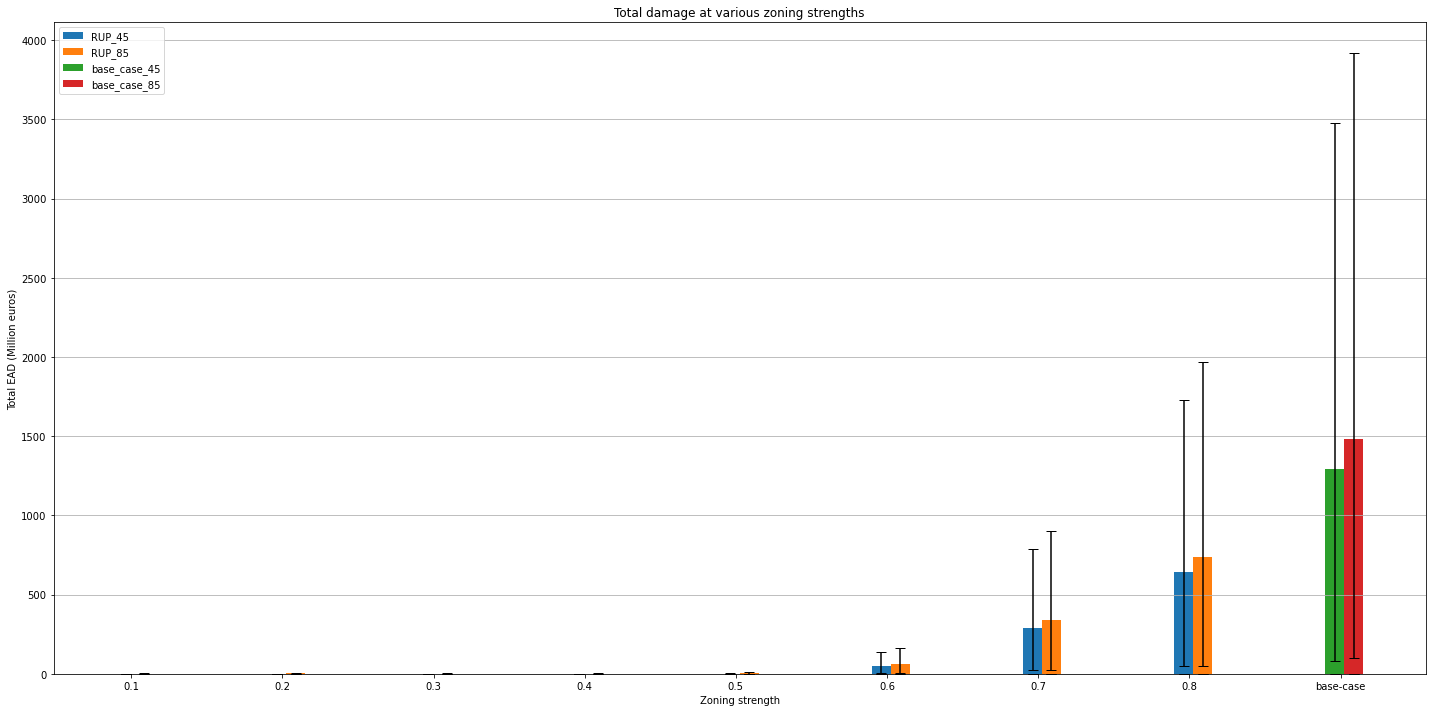

In [580]:
labels=['0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','base-case']
x_pos=np.arange(len(labels))
x = np.arange(len(y_values_OUP_45))
# Build the plot
fig, ax = plt.subplots(figsize=(20,10))
#ax.bar(x_pos, y_values_OUP_85,
#       yerr=y_errors_OUP_85.T,
#       #align='center',
#       alpha=0.8,
#       ecolor='black',
#       capsize=10)
barwidth=0.125
ax.bar(x+ barwidth, y_values_RUP_45_indus, width=barwidth, 
       label='RUP_45', yerr=y_errors_RUP_45_indus.T,capsize=5) # <----- 
ax.bar(x+ 2*barwidth, y_values_RUP_85_indus, width=barwidth, 
       label='RUP_85', yerr=y_errors_RUP_85_indus.T,capsize=5) # <----- 
ax.bar(x+barwidth, y_values_base_case_low_indus, width=barwidth, 
       label='base_case_45', yerr=y_errors_base_case_low_indus.T,capsize=5) # <----- 
ax.bar(x+2*barwidth, y_values_base_case_high_indus, width=barwidth, 
       label='base_case_85', yerr=y_errors_base_case_high_indus.T,capsize=5) # <----- 
ax.set_ylabel('Total EAD (Million euros)')
ax.set_xlabel('Zoning strength')
ax.set_xticks(x_pos+1.3*barwidth)#+2*barwidth#
#ax.set_xticks(x + barwidth + barwidth/2)
ax.set_xticklabels(labels)
ax.legend(loc='upper left')
ax.set_title('Total damage at various zoning strengths')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
#plt.savefig('bar_plot_with_error_bars.png')
plt.show()

### Urban-formal

In [581]:
y_errors_RUP_45_urb_form=np.array([[df1.iloc[1,2],df1.iloc[2,2]],[df2.iloc[1,2],df2.iloc[2,2]],[df3.iloc[1,2],df3.iloc[2,2]],[df4.iloc[1,2],df4.iloc[2,2]],[df5.iloc[1,2],df5.iloc[2,2]],[df51.iloc[1,2],df51.iloc[2,2]],
                                   [df52.iloc[1,2],df52.iloc[2,2]],[df53.iloc[1,2],df53.iloc[2,2]],[0,0]])

In [582]:
y_values_RUP_45_urb_form=[df1.iloc[0,2],df2.iloc[0,2],df3.iloc[0,2],df4.iloc[0,2],df5.iloc[0,2],df51.iloc[0,2],df52.iloc[0,2],df53.iloc[0,2],0]
#x_pos=[0.1,0.2,0.3,0.4,0.5]
labels=['0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','base-case']
x_pos=np.arange(len(labels))

In [583]:
y_errors_RUP_85_urb_form=np.array([[df6.iloc[1,2],df6.iloc[2,2]],[df7.iloc[1,2],df7.iloc[2,2]],[df8.iloc[1,2],df8.iloc[2,2]],[df9.iloc[1,2],df9.iloc[2,2]],[df10.iloc[1,2],df10.iloc[2,2]],[df101.iloc[1,2],df101.iloc[2,2]],
                                   [df102.iloc[1,2],df102.iloc[2,2]],[df103.iloc[1,2],df103.iloc[2,2]],[0,0]])

In [584]:
y_values_RUP_85_urb_form=[df6.iloc[0,2],df7.iloc[0,2],df8.iloc[0,2],df9.iloc[0,2],df10.iloc[0,2],df101.iloc[0,2],df102.iloc[0,2],df103.iloc[0,2],0]
#x_pos=[0.1,0.2,0.3,0.4,0.5]
labels=['0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','base-case']
x_pos=np.arange(len(labels))

In [585]:
y_errors_base_case_low_urb_form=np.array([[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[df21.iloc[1,2],df21.iloc[2,2]]])

In [586]:
y_values_base_case_low_urb_form=[0,0,0,0,0,0,0,0,df21.iloc[0,2]]
#x_pos=[0.1,0.2,0.3,0.4,0.5]
labels=['0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','base-case']
x_pos=np.arange(len(labels))

In [587]:
y_errors_base_case_high_urb_form=np.array([[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[df22.iloc[1,2],df22.iloc[2,2]]])

In [588]:
y_values_base_case_high_urb_form=[0,0,0,0,0,0,0,0,df22.iloc[0,2]]
#x_pos=[0.1,0.2,0.3,0.4,0.5]
labels=['0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','base-case']
x_pos=np.arange(len(labels))

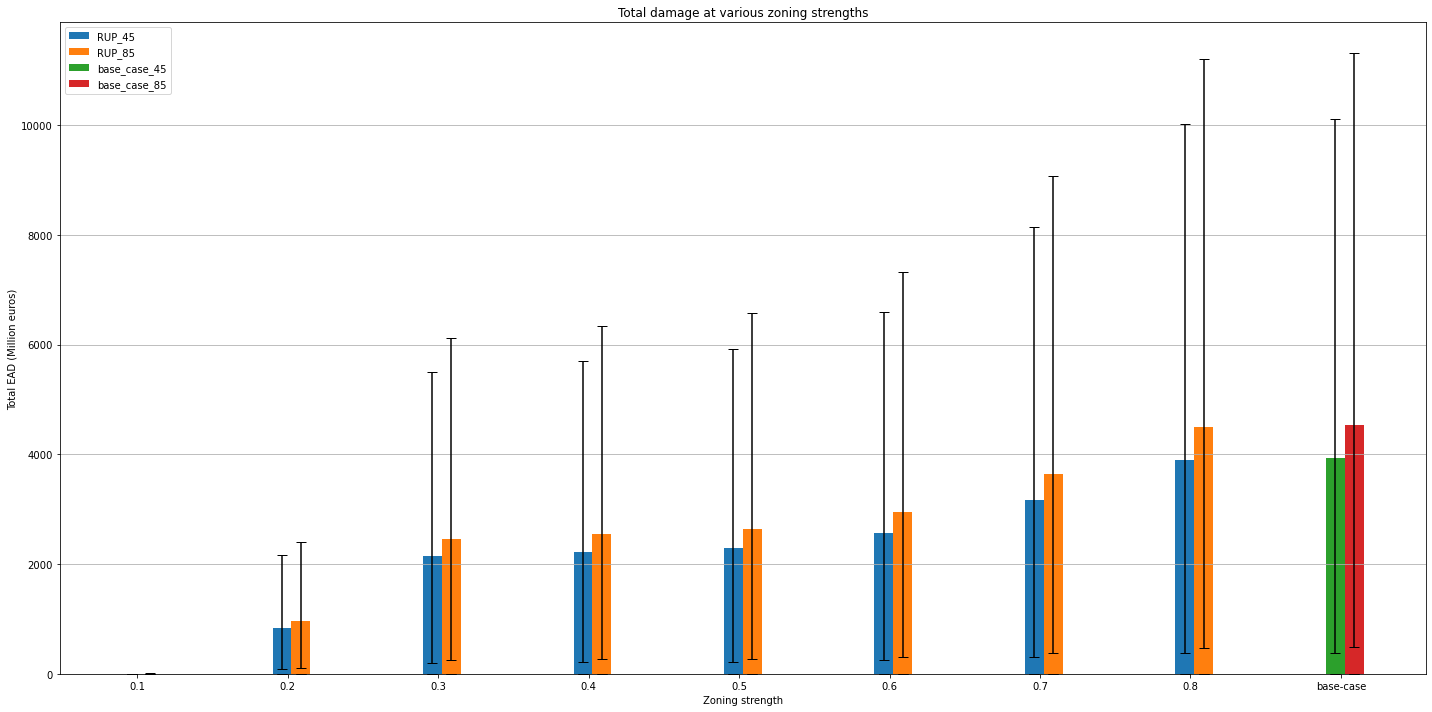

In [589]:
labels=['0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','base-case']
x_pos=np.arange(len(labels))
x = np.arange(len(y_values_OUP_45))
# Build the plot
fig, ax = plt.subplots(figsize=(20,10))
#ax.bar(x_pos, y_values_OUP_85,
#       yerr=y_errors_OUP_85.T,
#       #align='center',
#       alpha=0.8,
#       ecolor='black',
#       capsize=10)
barwidth=0.125
ax.bar(x+ barwidth, y_values_RUP_45_urb_form, width=barwidth, 
       label='RUP_45', yerr=y_errors_RUP_45_urb_form.T,capsize=5) # <----- 
ax.bar(x+ 2*barwidth, y_values_RUP_85_urb_form, width=barwidth, 
       label='RUP_85', yerr=y_errors_RUP_85_urb_form.T,capsize=5) # <----- 
ax.bar(x+barwidth, y_values_base_case_low_urb_form, width=barwidth, 
       label='base_case_45', yerr=y_errors_base_case_low_urb_form.T,capsize=5) # <----- 
ax.bar(x+2*barwidth, y_values_base_case_high_urb_form, width=barwidth, 
       label='base_case_85', yerr=y_errors_base_case_high_urb_form.T,capsize=5) # <----- 
ax.set_ylabel('Total EAD (Million euros)')
ax.set_xlabel('Zoning strength')
ax.set_xticks(x_pos+1.3*barwidth)#+2*barwidth#
#ax.set_xticks(x + barwidth + barwidth/2)
ax.set_xticklabels(labels)
ax.legend(loc='upper left')
ax.set_title('Total damage at various zoning strengths')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
#plt.savefig('bar_plot_with_error_bars.png')
plt.show()

### Urban-informal

In [592]:
y_errors_RUP_45_urb_inform=np.array([[df1.iloc[1,3],df1.iloc[2,3]],[df2.iloc[1,3],df2.iloc[2,3]],[df3.iloc[1,3],df3.iloc[2,3]],[df4.iloc[1,3],df4.iloc[2,3]],[df5.iloc[1,3],df5.iloc[2,3]],[df51.iloc[1,3],df51.iloc[2,3]],
                                     [df52.iloc[1,3],df52.iloc[2,3]],[df53.iloc[1,3],df53.iloc[2,3]],[0,0]])

In [593]:
y_values_RUP_45_urb_inform=[df1.iloc[0,3],df2.iloc[0,3],df3.iloc[0,3],df4.iloc[0,3],df5.iloc[0,3],df51.iloc[0,3],df52.iloc[0,3],df53.iloc[0,3],0]
#x_pos=[0.1,0.2,0.3,0.4,0.5]
labels=['0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','base-case']
x_pos=np.arange(len(labels))

In [594]:
y_errors_RUP_85_urb_inform=np.array([[df6.iloc[1,3],df6.iloc[2,3]],[df7.iloc[1,3],df7.iloc[2,3]],[df8.iloc[1,3],df8.iloc[2,3]],[df9.iloc[1,3],df9.iloc[2,3]],[df10.iloc[1,3],df10.iloc[2,3]],[df101.iloc[1,3],df101.iloc[2,3]],
                                     [df102.iloc[1,3],df102.iloc[2,3]],[df103.iloc[1,3],df103.iloc[2,3]],[0,0]])

In [595]:
y_values_RUP_85_urb_inform=[df6.iloc[0,3],df7.iloc[0,3],df8.iloc[0,3],df9.iloc[0,3],df10.iloc[0,3],df101.iloc[0,3],df102.iloc[0,3],df103.iloc[0,3],0]
#x_pos=[0.1,0.2,0.3,0.4,0.5]
labels=['0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','base-case']
x_pos=np.arange(len(labels))

In [596]:
y_errors_base_case_low_urb_inform=np.array([[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[df21.iloc[1,3],df21.iloc[2,3]]])

In [597]:
y_values_base_case_low_urb_inform=[0,0,0,0,0,0,0,0,df21.iloc[0,3]]
#x_pos=[0.1,0.2,0.3,0.4,0.5]
labels=['0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','base-case']
x_pos=np.arange(len(labels))

In [598]:
y_errors_base_case_high_urb_inform=np.array([[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[df22.iloc[1,3],df22.iloc[2,3]]])

In [599]:
y_values_base_case_high_urb_inform=[0,0,0,0,0,0,0,0,df22.iloc[0,3]]
#x_pos=[0.1,0.2,0.3,0.4,0.5]
labels=['0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','base-case']
x_pos=np.arange(len(labels))

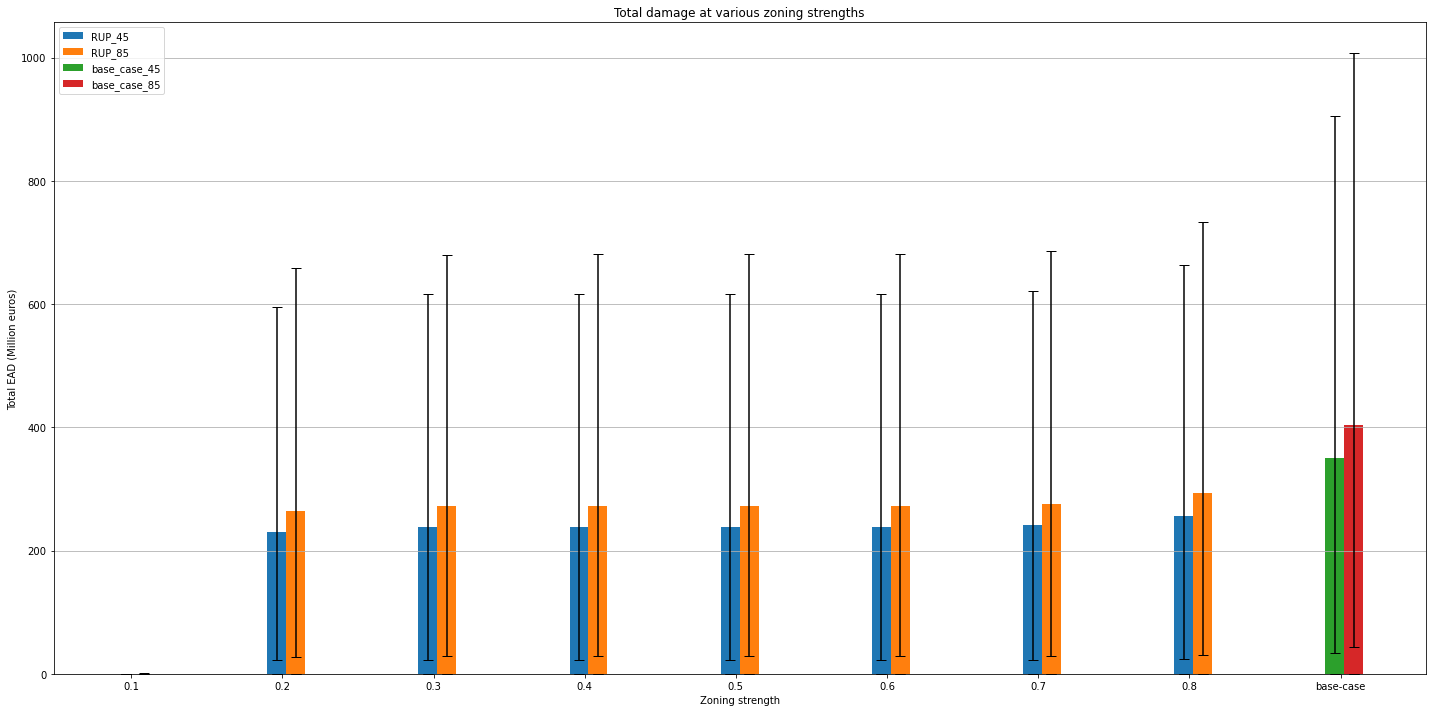

In [600]:
labels=['0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','base-case']
x_pos=np.arange(len(labels))
x = np.arange(len(y_values_OUP_45))
# Build the plot
fig, ax = plt.subplots(figsize=(20,10))
#ax.bar(x_pos, y_values_OUP_85,
#       yerr=y_errors_OUP_85.T,
#       #align='center',
#       alpha=0.8,
#       ecolor='black',
#       capsize=10)
barwidth=0.125
ax.bar(x+ barwidth, y_values_RUP_45_urb_inform, width=barwidth, 
       label='RUP_45', yerr=y_errors_RUP_45_urb_inform.T,capsize=5) # <----- 
ax.bar(x+ 2*barwidth, y_values_RUP_85_urb_inform, width=barwidth, 
       label='RUP_85', yerr=y_errors_RUP_85_urb_inform.T,capsize=5) # <----- 
ax.bar(x+barwidth, y_values_base_case_low_urb_inform, width=barwidth, 
       label='base_case_45', yerr=y_errors_base_case_low_urb_inform.T,capsize=5) # <----- 
ax.bar(x+2*barwidth, y_values_base_case_high_urb_inform, width=barwidth, 
       label='base_case_85', yerr=y_errors_base_case_high_urb_inform.T,capsize=5) # <----- 
ax.set_ylabel('Total EAD (Million euros)')
ax.set_xlabel('Zoning strength')
ax.set_xticks(x_pos+1.3*barwidth)#+2*barwidth#
#ax.set_xticks(x + barwidth + barwidth/2)
ax.set_xticklabels(labels)
ax.legend(loc='upper left')
ax.set_title('Total damage at various zoning strengths')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
#plt.savefig('bar_plot_with_error_bars.png')
plt.show()

### Urban-villages

In [601]:
y_errors_RUP_45_urb_vil=np.array([[df1.iloc[1,4],df1.iloc[2,4]],[df2.iloc[1,4],df2.iloc[2,4]],[df3.iloc[1,4],df3.iloc[2,4]],[df4.iloc[1,4],df4.iloc[2,4]],[df5.iloc[1,4],df5.iloc[2,4]],[df51.iloc[1,4],df51.iloc[2,4]],
                                  [df52.iloc[1,4],df52.iloc[2,4]],[df53.iloc[1,4],df53.iloc[2,4]],[0,0]])

In [602]:
y_values_RUP_45_urb_vil=[df1.iloc[0,4],df2.iloc[0,4],df3.iloc[0,4],df4.iloc[0,4],df5.iloc[0,4],df51.iloc[0,4],df52.iloc[0,4],df53.iloc[0,4],0]
#x_pos=[0.1,0.2,0.3,0.4,0.5]
labels=['0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','base-case']
x_pos=np.arange(len(labels))

In [603]:
y_errors_RUP_85_urb_vil=np.array([[df6.iloc[1,4],df6.iloc[2,4]],[df7.iloc[1,4],df7.iloc[2,4]],[df8.iloc[1,4],df8.iloc[2,4]],[df9.iloc[1,4],df9.iloc[2,4]],[df10.iloc[1,4],df10.iloc[2,4]],[df101.iloc[1,4],df101.iloc[2,4]],
                                  [df102.iloc[1,4],df102.iloc[2,4]],[df103.iloc[1,4],df103.iloc[2,4]],[0,0]])

In [604]:
y_values_RUP_85_urb_vil=[df6.iloc[0,4],df7.iloc[0,4],df8.iloc[0,4],df9.iloc[0,4],df10.iloc[0,4],df101.iloc[0,4],df102.iloc[0,4],df103.iloc[0,4],0]
#x_pos=[0.1,0.2,0.3,0.4,0.5]
labels=['0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','base-case']
x_pos=np.arange(len(labels))

In [605]:
y_errors_base_case_low_urb_vil=np.array([[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[df21.iloc[1,4],df21.iloc[2,4]]])

In [606]:
y_values_base_case_low_urb_vil=[0,0,0,0,0,0,0,0,df21.iloc[0,4]]
#x_pos=[0.1,0.2,0.3,0.4,0.5]
labels=['0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','base-case']
x_pos=np.arange(len(labels))

In [607]:
y_errors_base_case_high_urb_vil=np.array([[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[df22.iloc[1,4],df22.iloc[2,4]]])

In [608]:
y_values_base_case_high_urb_vil=[0,0,0,0,0,0,0,0,df22.iloc[0,4]]
#x_pos=[0.1,0.2,0.3,0.4,0.5]
labels=['0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','base-case']
x_pos=np.arange(len(labels))

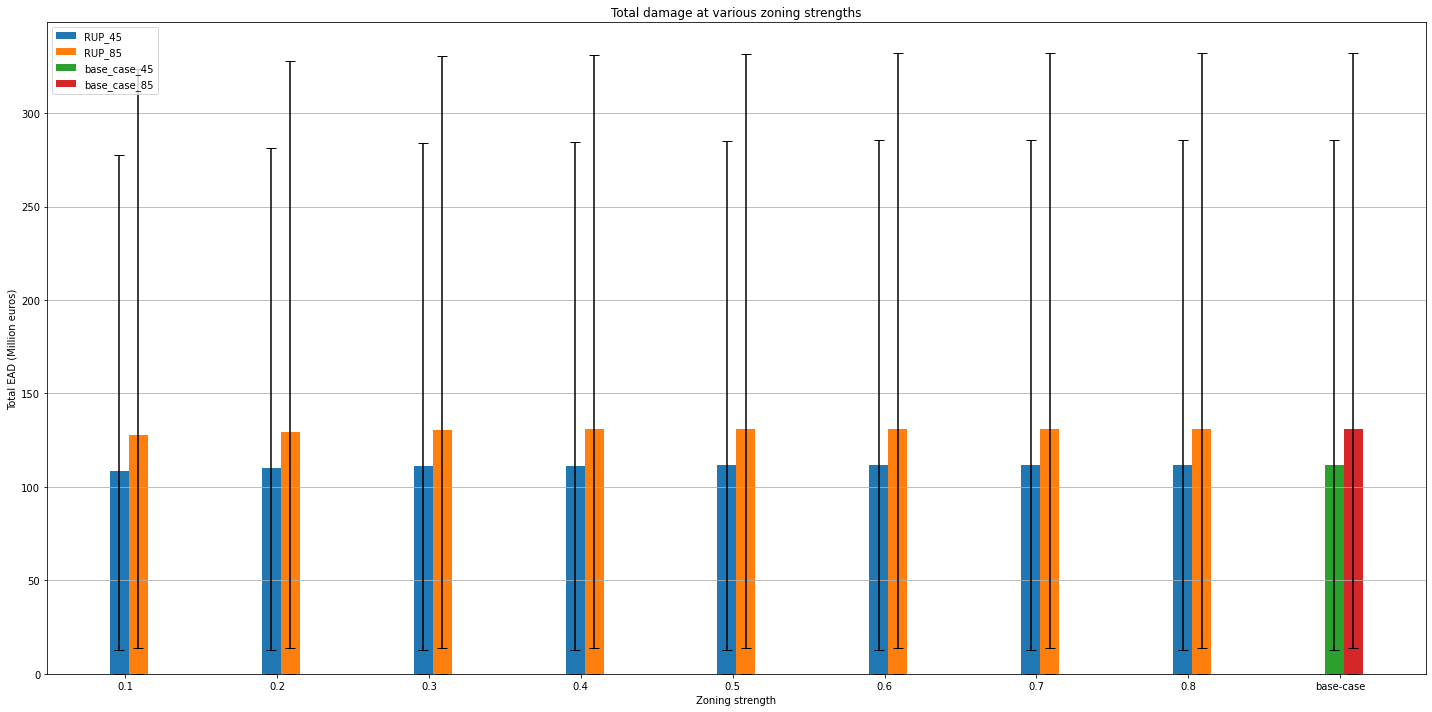

In [609]:
labels=['0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','base-case']
x_pos=np.arange(len(labels))
x = np.arange(len(y_values_OUP_45))
# Build the plot
fig, ax = plt.subplots(figsize=(20,10))
#ax.bar(x_pos, y_values_OUP_85,
#       yerr=y_errors_OUP_85.T,
#       #align='center',
#       alpha=0.8,
#       ecolor='black',
#       capsize=10)
barwidth=0.125
ax.bar(x+ barwidth, y_values_RUP_45_urb_vil, width=barwidth, 
       label='RUP_45', yerr=y_errors_RUP_45_urb_vil.T,capsize=5) # <----- 
ax.bar(x+ 2*barwidth, y_values_RUP_85_urb_vil, width=barwidth, 
       label='RUP_85', yerr=y_errors_RUP_85_urb_vil.T,capsize=5) # <----- 
ax.bar(x+barwidth, y_values_base_case_low_urb_vil, width=barwidth, 
       label='base_case_45', yerr=y_errors_base_case_low_urb_vil.T,capsize=5) # <----- 
ax.bar(x+2*barwidth, y_values_base_case_high_urb_vil, width=barwidth, 
       label='base_case_85', yerr=y_errors_base_case_high_urb_vil.T,capsize=5) # <----- 
ax.set_ylabel('Total EAD (Million euros)')
ax.set_xlabel('Zoning strength')
ax.set_xticks(x_pos+1.3*barwidth)#+2*barwidth#
#ax.set_xticks(x + barwidth + barwidth/2)
ax.set_xticklabels(labels)
ax.legend(loc='upper left')
ax.set_title('Total damage at various zoning strengths')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
#plt.savefig('bar_plot_with_error_bars.png')
plt.show()

In [324]:
total_damage_low.reverse()

In [325]:
annual_exceedance_prob=[0.001,0.002,0.004,0.01,0.02,0.04,0.1,0.2,0.5]

In [326]:
rc=(total_damage_low[-1]-total_damage_low[-2])/(annual_exceedance_prob[-1]-annual_exceedance_prob[-2])

In [327]:
annual_exceedance_prob=[0,0.001,0.002,0.004,0.01,0.02,0.04,0.1,0.2,0.5,1]

In [328]:
total_damage_low.append(total_damage_low[-1]+rc*((annual_exceedance_prob[-1]-annual_exceedance_prob[-2]))) #damage at p=1


In [329]:
total_damage_low.insert(0,1.5*total_damage_low[1]) #damage at p=0

In [330]:
total_unc_low.reverse()
total_unc_low=np.array(total_unc_low)

In [331]:
first_tuples=[]
for element in total_unc_low:
    first_tuples.append(element[0])
annual_exceedance_prob=[0.001,0.002,0.004,0.01,0.02,0.04,0.1,0.2,0.5]
rc=(first_tuples[-1]-first_tuples[-2])/(annual_exceedance_prob[-1]-annual_exceedance_prob[-2])
annual_exceedance_prob=[0,0.001,0.002,0.004,0.01,0.02,0.04,0.1,0.2,0.5,1]
first_tuples.append(first_tuples[-1]+rc*((annual_exceedance_prob[-1]-annual_exceedance_prob[-2]))) #damage at p=1
first_tuples.insert(0,1.5*first_tuples[1]) #uncertainty at p=0

In [332]:
first_tuples

[12810.743595303335,
 8851.542713250346,
 8540.495730202223,
 8146.807934312443,
 7663.008770691271,
 7281.336021893949,
 6792.934846922441,
 6126.875346844126,
 5538.486417254388,
 3784.484956835174,
 861.1491894698183]

In [333]:
second_tuples=[]
for element in total_unc_low:
    second_tuples.append(element[1])
annual_exceedance_prob=[0.001,0.002,0.004,0.01,0.02,0.04,0.1,0.2,0.5]
rc=(second_tuples[-1]-second_tuples[-2])/(annual_exceedance_prob[-1]-annual_exceedance_prob[-2])
annual_exceedance_prob=[0,0.001,0.002,0.004,0.01,0.02,0.04,0.1,0.2,0.5,1]
second_tuples.append(second_tuples[-1]+rc*((annual_exceedance_prob[-1]-annual_exceedance_prob[-2]))) #damage at p=1
second_tuples.insert(0,1.5*second_tuples[1]) #uncertainty at p=0

In [334]:
annual_exceedance_prob=[0,0.001,0.002,0.004,0.01,0.02,0.04,0.1,0.2,0.5,1]

In [335]:
uncertainties=[first_tuples,second_tuples]

In [336]:
upper_unc=np.add(total_damage_low,second_tuples) #point creation
lower_unc=np.subtract(total_damage_low,first_tuples)

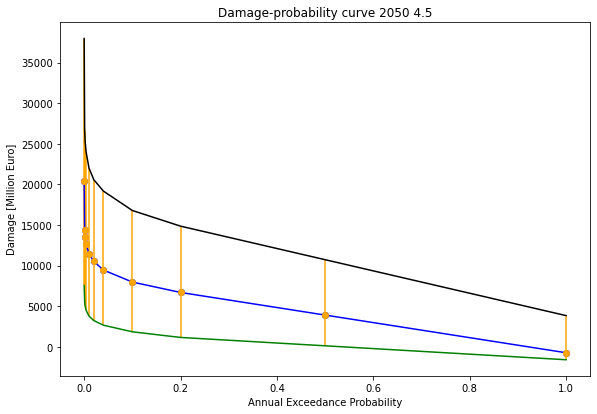

In [337]:
fig, ax = plt.subplots()
plt.scatter(annual_exceedance_prob,total_damage_low, color="blue")
plt.errorbar(annual_exceedance_prob,total_damage_low,yerr=uncertainties, fmt="o", color="orange")
plt.plot(annual_exceedance_prob,total_damage_low, color="blue")
plt.plot(annual_exceedance_prob, upper_unc,color="black")
plt.plot(annual_exceedance_prob, lower_unc, color="green")
#ax.plot(flood_depth, damage_func2, linewidth=2.0)
#ax.plot(flood_depth, damage_func3, linewidth=2.0)
#ax.plot(flood_depth, damage_func4, linewidth=2.0)
#ax.set(xlim=(0, 6), xticks=np.arange(1, 8),
#       ylim=(0, 600), yticks=np.arange(0, 600,30))
#ax.legend(['Logarithmic fit: Y=' + str(round(normal_fit[0],2))+'*log(flood_depth)^2 +'+str(round(normal_fit[1],2))+'*log(flood_depth) +' + str(round(normal_fit[2],2)),
#           'Upper-bound fit: Y=' + str(round(upper_fit[0],2))+'*log(flood_depth)^2 +'+str(round(upper_fit[1],2))+'*log(flood_depth) +' + str(round(upper_fit[2],2)),
#           'Lower-bound fit: Y=Max(0,' + str(round(lower_fit[0],2))+'*log(flood_depth)^2 +'+str(round(lower_fit[1],2))+'*log(flood_depth) +' + str(round(lower_fit[2],2))+')'],loc=2)
plt.xlabel("Annual Exceedance Probability")
plt.ylabel("Damage [Million Euro]")
plt.title("Damage-probability curve 2050 4.5")
fig.set_size_inches(9.5, 6.5)
#fig.savefig('damage_curve_trans.png', dpi=100)
plt.show()

In [338]:
import numpy as np
from sklearn.metrics import auc


print("expected AED is",auc(annual_exceedance_prob,total_damage_low))
print("AED lowerbound is",auc(annual_exceedance_prob,lower_unc))
print("AED upperbound is",auc(annual_exceedance_prob,upper_unc))

expected AED is 4083.7300197602613
AED lowerbound is 253.90503424603685
AED upperbound is 10999.753743837082


## High AED

In [339]:
total_damage_high,total_unc_high=func_calculate_damage(r'combined_rasters\high')

avg_models_high_2.tif
avg_models_high_5.tif
avg_models_high_10.tif
avg_models_high_25.tif
avg_models_high_50.tif
avg_models_high_100.tif
avg_models_high_250.tif
avg_models_high_500.tif
avg_models_high_1000.tif


In [340]:
total_damage_high.reverse()

In [341]:
annual_exceedance_prob=[0.001,0.002,0.004,0.01,0.02,0.04,0.1,0.2,0.5]

In [342]:
rc=(total_damage_high[-1]-total_damage_high[-2])/(annual_exceedance_prob[-1]-annual_exceedance_prob[-2])

In [343]:
annual_exceedance_prob=[0,0.001,0.002,0.004,0.01,0.02,0.04,0.1,0.2,0.5,1]

In [344]:
total_damage_high.append(total_damage_high[-1]+rc*((annual_exceedance_prob[-1]-annual_exceedance_prob[-2]))) #damage at p=1


In [345]:
total_damage_high.insert(0,1.5*total_damage_high[1]) #damage at p=0

In [346]:
total_unc_high.reverse()
total_unc_high=np.array(total_unc_high)

In [347]:
first_tuples=[]
for element in total_unc_high:
    first_tuples.append(element[0])
annual_exceedance_prob=[0.001,0.002,0.004,0.01,0.02,0.04,0.1,0.2,0.5]
rc=(first_tuples[-1]-first_tuples[-2])/(annual_exceedance_prob[-1]-annual_exceedance_prob[-2])
print(rc)
print(first_tuples[-1])
annual_exceedance_prob=[0,0.001,0.002,0.004,0.01,0.02,0.04,0.1,0.2,0.5,1]
first_tuples.append(first_tuples[-1]+rc*((annual_exceedance_prob[-1]-annual_exceedance_prob[-2]))) #damage at p=1
first_tuples.insert(0,1.5*first_tuples[1]) #uncertainty at p=0

-4937.129859589683
4466.413645529752


In [348]:
first_tuples

[14022.29787251915,
 9858.616739958652,
 9348.198581679433,
 8975.801056171083,
 8393.357138134348,
 7871.031263804609,
 7389.054943800681,
 6623.6807120411295,
 5947.552603406657,
 4466.413645529752,
 1997.8487157349105]

In [349]:
second_tuples=[]
for element in total_unc_high:
    second_tuples.append(element[1])
annual_exceedance_prob=[0.001,0.002,0.004,0.01,0.02,0.04,0.1,0.2,0.5]
rc=(second_tuples[-1]-second_tuples[-2])/(annual_exceedance_prob[-1]-annual_exceedance_prob[-2])
annual_exceedance_prob=[0,0.001,0.002,0.004,0.01,0.02,0.04,0.1,0.2,0.5,1]
second_tuples.append(second_tuples[-1]+rc*((annual_exceedance_prob[-1]-annual_exceedance_prob[-2]))) #damage at p=1
second_tuples.insert(0,1.5*second_tuples[1]) #uncertainty at p=0

In [350]:
annual_exceedance_prob=[0,0.001,0.002,0.004,0.01,0.02,0.04,0.1,0.2,0.5,1]

In [351]:
uncertainties=[first_tuples,second_tuples]

In [352]:
upper_unc=np.add(total_damage_high,second_tuples) #point creation
lower_unc=np.subtract(total_damage_high,first_tuples)

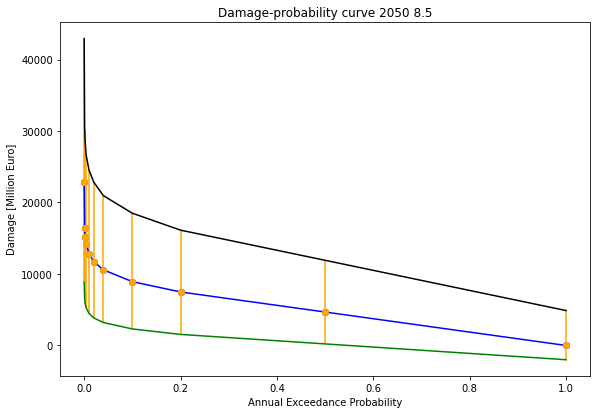

In [353]:
fig, ax = plt.subplots()
plt.scatter(annual_exceedance_prob,total_damage_high, color="blue")
plt.errorbar(annual_exceedance_prob,total_damage_high,yerr=uncertainties, fmt="o", color="orange")
plt.plot(annual_exceedance_prob,total_damage_high, color="blue")
plt.plot(annual_exceedance_prob, upper_unc,color="black")
plt.plot(annual_exceedance_prob, lower_unc, color="green")
#ax.plot(flood_depth, damage_func2, linewidth=2.0)
#ax.plot(flood_depth, damage_func3, linewidth=2.0)
#ax.plot(flood_depth, damage_func4, linewidth=2.0)
#ax.set(xlim=(0, 6), xticks=np.arange(1, 8),
#       ylim=(0, 600), yticks=np.arange(0, 600,30))
#ax.legend(['Logarithmic fit: Y=' + str(round(normal_fit[0],2))+'*log(flood_depth)^2 +'+str(round(normal_fit[1],2))+'*log(flood_depth) +' + str(round(normal_fit[2],2)),
#           'Upper-bound fit: Y=' + str(round(upper_fit[0],2))+'*log(flood_depth)^2 +'+str(round(upper_fit[1],2))+'*log(flood_depth) +' + str(round(upper_fit[2],2)),
#           'Lower-bound fit: Y=Max(0,' + str(round(lower_fit[0],2))+'*log(flood_depth)^2 +'+str(round(lower_fit[1],2))+'*log(flood_depth) +' + str(round(lower_fit[2],2))+')'],loc=2)
plt.xlabel("Annual Exceedance Probability")
plt.ylabel("Damage [Million Euro]")
plt.title("Damage-probability curve 2050 8.5")
fig.set_size_inches(9.5, 6.5)
#fig.savefig('damage_curve_trans.png', dpi=100)
plt.show()

In [354]:
import numpy as np
from sklearn.metrics import auc

print("expected AED is",auc(annual_exceedance_prob,total_damage_high))
print("AED lowerbound is",auc(annual_exceedance_prob,lower_unc))
print("AED upperbound is",auc(annual_exceedance_prob,upper_unc))

expected AED is 4863.7986337848015
AED lowerbound is 310.7962274069582
AED upperbound is 12253.325106604792
